# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
!pip install optuna
!pip install catboost
!pip install xgboost
!pip install lightgbm
!pip install shap
!pip install imblearn
!pip install lime
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-pac


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip show

In [1]:
import numpy as np
import pandas as pd
import optuna
import shap

from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier, BaggingClassifier,HistGradientBoostingClassifier,
    GradientBoostingClassifier, VotingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 데이터 읽어오기


In [7]:
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv("train.csv")
train_data

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Collect Date_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,2024-04-25 11:10:00,1,OK,240.0,NaN,...,7,NaN,NaN,127,NaN,NaN,1,NaN,NaN,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,2023-09-19 14:30:00,1,OK,240.0,NaN,...,185,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,2024-03-05 09:30:00,1,OK,1000.0,NaN,...,10,NaN,NaN,73,NaN,NaN,1,NaN,NaN,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,2023-09-25 15:40:00,1,OK,1000.0,NaN,...,268,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,2023-06-27 13:20:00,1,OK,240.0,NaN,...,121,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,2023-09-14 15:50:00,1,OK,240.0,NaN,...,318,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,2024-04-10 14:20:00,1,OK,1000.0,NaN,...,14,NaN,NaN,197,NaN,NaN,1,NaN,NaN,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,2024-02-22 08:40:00,1,OK,240.0,NaN,...,1,NaN,NaN,27,NaN,NaN,1,NaN,NaN,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,2023-07-25 11:00:00,1,OK,1000.0,NaN,...,117,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal


In [8]:
test_data = pd.read_csv("test.csv")
test_data

,Set ID,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Collect Date_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,0001be084fbc4aaa9d921f39e595961b,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3J1XF767-1,2023-09-15 13:20:00,1,OK,1000.0,...,195,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
1,0005bbd180064abd99e63f9ed3e1ac80,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4B1XD472-2,2024-02-06 16:50:00,1,OK,1000.0,...,14,NaN,NaN,256,NaN,NaN,1,NaN,NaN,NaN
2,000948934c4140d883d670adcb609584,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3H1XE355-1,2023-07-14 11:30:00,1,OK,240.0,...,98,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
3,000a6bfd02874c6296dc7b2e9c5678a7,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3L1XA128-1,2023-11-03 08:00:00,1,OK,1000.0,...,14,NaN,NaN,0,NaN,NaN,1,NaN,NaN,NaN
4,0018e78ce91343678716e2ea27a51c95,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4A1XA639-1,2023-12-23 14:00:00,1,OK,240.0,...,1,NaN,NaN,215,NaN,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1XB597-1,2023-10-18 11:10:00,1,OK,1000.0,...,14,NaN,NaN,131,NaN,NaN,1,NaN,NaN,NaN
17357,ffed8923c8a448a98afc641b770be153,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4A1XB974-1,2024-01-02 15:00:00,1,OK,1000.0,...,12,NaN,NaN,279,NaN,NaN,1,NaN,NaN,NaN
17358,fff1e73734da40adbe805359b3efb462,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3L1XA998-1,2023-11-15 09:10:00,1,OK,240.0,...,4,NaN,NaN,66,NaN,NaN,1,NaN,NaN,NaN
17359,fff8e38bdd09470baf95f71e92075dec,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1XC376-1,2023-05-18 14:20:00,1,OK,240.0,...,117,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN


### 데이터 전처리 열삭제

In [9]:
# 고유값 한 개인 열 삭제 
#(왜 그렇게 했는지 만약 새로운 데이터 생성 추가되면 어떻게 할지?) 생산 line 시간순으로 새로운 데이터 추가될텐데 그럴 경우 대답?
train_data = train_data.loc[:, train_data.nunique() > 1]
test_data = test_data.loc[:, test_data.nunique() > 1]

In [10]:
columns_train = set(train_data.columns)
columns_test = set(test_data.columns)

# train에는 있고 test에는 없는 컬럼
diff_in_train = columns_train - columns_test
print(diff_in_train)
# test에는 있고 test에는 없는 컬럼
diff_in_test = columns_test - columns_train
print(diff_in_test)

{'target'}
{'Set ID'}


In [11]:
def correct_shifted_rows_Dam(row):
    # B 열이 NaN인 경우 데이터가 밀렸다고 가정
    if row['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'] == row['HEAD Standby Position X Collect Result_Dam']:
        # 데이터를 왼쪽으로 한 칸씩 이동
        row['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = row['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam']
        row['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'] = row['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam']
        row['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] = row['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam']
        
        row['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] = row['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']
        row['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] = row['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']
        row['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'] = row['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam']
    
        row['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'] = row['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam']
        row['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'] = row['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']
        row['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'] = row['HEAD Standby Position X Collect Result_Dam']
        
        row['HEAD Standby Position X Collect Result_Dam'] = row['HEAD Standby Position Y Collect Result_Dam']
        row['HEAD Standby Position Y Collect Result_Dam'] = row['HEAD Standby Position Z Collect Result_Dam']
        row['HEAD Standby Position Z Collect Result_Dam'] = row['Head Clean Position X Collect Result_Dam'] 
        
        row['Head Clean Position X Collect Result_Dam'] = row['Head Clean Position Y Collect Result_Dam']
        row['Head Clean Position Y Collect Result_Dam'] = row['Head Clean Position Z Collect Result_Dam']
        row['Head Clean Position Z Collect Result_Dam'] = row['Head Purge Position X Collect Result_Dam']
        
        row['Head Purge Position X Collect Result_Dam'] = row['Head Purge Position Y Collect Result_Dam']
        row['Head Purge Position Y Collect Result_Dam'] = row['Head Purge Position Z Collect Result_Dam']
        row['Head Purge Position Z Collect Result_Dam'] = row['Head Zero Position X Collect Result_Dam']
        
        
        row['Head Zero Position X Collect Result_Dam'] = row['Head Zero Position Y Collect Result_Dam']
        row['Head Zero Position Y Collect Result_Dam'] = row['Head Zero Position Z Collect Result_Dam']
        row['Head Zero Position Z Collect Result_Dam'] = row['Machine Tact time Collect Result_Dam']
        
        row['Machine Tact time Collect Result_Dam'] = row['PalletID Collect Result_Dam']
        row['PalletID Collect Result_Dam'] = row['Production Qty Collect Result_Dam']
        row['Production Qty Collect Result_Dam'] = row['Receip No Collect Result_Dam']
        row['Receip No Collect Result_Dam'] = row['Stage1 Circle1 Distance Speed Collect Result_Dam']
        
        row['Stage1 Circle1 Distance Speed Collect Result_Dam'] = row['Stage1 Circle2 Distance Speed Collect Result_Dam']
        row['Stage1 Circle2 Distance Speed Collect Result_Dam'] = row['Stage1 Circle3 Distance Speed Collect Result_Dam']
        row['Stage1 Circle3 Distance Speed Collect Result_Dam'] = row['Stage1 Circle4 Distance Speed Collect Result_Dam']
        row['Stage1 Circle4 Distance Speed Collect Result_Dam'] = row['Stage1 Line1 Distance Speed Collect Result_Dam']
        
        row['Stage1 Line1 Distance Speed Collect Result_Dam'] = row['Stage1 Line2 Distance Speed Collect Result_Dam']
        row['Stage1 Line2 Distance Speed Collect Result_Dam'] = row['Stage1 Line3 Distance Speed Collect Result_Dam']
        row['Stage1 Line3 Distance Speed Collect Result_Dam'] = row['Stage1 Line4 Distance Speed Collect Result_Dam']
        row['Stage1 Line4 Distance Speed Collect Result_Dam'] = row['Stage2 Circle1 Distance Speed Collect Result_Dam']
        
        
        row['Stage2 Circle1 Distance Speed Collect Result_Dam'] = row['Stage2 Circle2 Distance Speed Collect Result_Dam']
        row['Stage2 Circle2 Distance Speed Collect Result_Dam'] = row['Stage2 Circle3 Distance Speed Collect Result_Dam']
        row['Stage2 Circle3 Distance Speed Collect Result_Dam'] = row['Stage2 Circle4 Distance Speed Collect Result_Dam']
        row['Stage2 Circle4 Distance Speed Collect Result_Dam'] = row['Stage2 Line1 Distance Speed Collect Result_Dam']
        
        row['Stage2 Line1 Distance Speed Collect Result_Dam'] = row['Stage2 Line2 Distance Speed Collect Result_Dam']
        row['Stage2 Line2 Distance Speed Collect Result_Dam'] = row['Stage2 Line3 Distance Speed Collect Result_Dam']
        row['Stage2 Line3 Distance Speed Collect Result_Dam'] = row['Stage2 Line4 Distance Speed Collect Result_Dam']
        row['Stage2 Line4 Distance Speed Collect Result_Dam'] = row['Stage3 Circle1 Distance Speed Collect Result_Dam']
        
        row['Stage3 Circle1 Distance Speed Collect Result_Dam'] = row['Stage3 Circle2 Distance Speed Collect Result_Dam']
        row['Stage3 Circle2 Distance Speed Collect Result_Dam'] = row['Stage3 Circle3 Distance Speed Collect Result_Dam']
        row['Stage3 Circle3 Distance Speed Collect Result_Dam'] = row['Stage3 Circle4 Distance Speed Collect Result_Dam']
        row['Stage3 Circle4 Distance Speed Collect Result_Dam'] = row['Stage3 Line1 Distance Speed Collect Result_Dam']
        
        row['Stage3 Line1 Distance Speed Collect Result_Dam'] = row['Stage3 Line2 Distance Speed Collect Result_Dam']
        row['Stage3 Line2 Distance Speed Collect Result_Dam'] = row['Stage3 Line3 Distance Speed Collect Result_Dam']
        row['Stage3 Line3 Distance Speed Collect Result_Dam'] = row['Stage3 Line4 Distance Speed Collect Result_Dam']
        row['Stage3 Line4 Distance Speed Collect Result_Dam'] = row['THICKNESS 1 Collect Result_Dam']
        
        row['THICKNESS 1 Collect Result_Dam'] = row['THICKNESS 2 Collect Result_Dam']
        row['THICKNESS 2 Collect Result_Dam'] = row['THICKNESS 3 Collect Result_Dam']
        row['THICKNESS 3 Collect Result_Dam'] = row['WorkMode Collect Result_Dam']
        row['WorkMode Collect Result_Dam'] = 7
        
        
        # 마지막 열은 None 또는 NaN으로 설정
    return row

In [12]:
def correct_shifted_rows_Fill1(row):
    # B 열이 NaN인 경우 데이터가 밀렸다고 가정
    if row['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'] == row['HEAD Standby Position X Collect Result_Fill1']:
        # 데이터를 왼쪽으로 한 칸씩 이동
        row['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = row['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1']
        row['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'] = row['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1']
        row['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'] = row['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1']
        
        row['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] = row['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']
        row['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] = row['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']
        row['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'] = row['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1']
    
        row['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'] = row['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1']
        row['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'] = row['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1']
        row['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'] = row['HEAD Standby Position X Collect Result_Fill1']
        
        row['HEAD Standby Position X Collect Result_Fill1'] = row['HEAD Standby Position Y Collect Result_Fill1']
        row['HEAD Standby Position Y Collect Result_Fill1'] = row['HEAD Standby Position Z Collect Result_Fill1']
        row['HEAD Standby Position Z Collect Result_Fill1'] = row['Head Clean Position X Collect Result_Fill1'] 
        
        row['Head Clean Position X Collect Result_Fill1'] = row['Head Clean Position Y Collect Result_Fill1']
        row['Head Clean Position Y Collect Result_Fill1'] = row['Head Clean Position Z Collect Result_Fill1']
        row['Head Clean Position Z Collect Result_Fill1'] = row['Head Purge Position X Collect Result_Fill1']
        
        row['Head Purge Position X Collect Result_Fill1'] = row['Head Purge Position Y Collect Result_Fill1']
        row['Head Purge Position Y Collect Result_Fill1'] = row['Head Purge Position Z Collect Result_Fill1']
        row['Head Purge Position Z Collect Result_Fill1'] = row['Machine Tact time Collect Result_Fill1']
        
        row['Machine Tact time Collect Result_Fill1'] = row['PalletID Collect Result_Fill1']
        row['PalletID Collect Result_Fill1'] = row['Production Qty Collect Result_Fill1']
        row['Production Qty Collect Result_Fill1'] = row['Receip No Collect Result_Fill1']
        row['Receip No Collect Result_Fill1'] = row['WorkMode Collect Result_Fill1']
        row['WorkMode Collect Result_Fill1'] = 7
        
        
        # 마지막 열은 None 또는 NaN으로 설정
    return row

In [13]:
def correct_shifted_rows_Fill2(row):
    # B 열이 NaN인 경우 데이터가 밀렸다고 가정
    if row['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'] == row['HEAD Standby Position X Collect Result_Fill2']:
        # 데이터를 왼쪽으로 한 칸씩 이동
        row['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = row['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2']
        row['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'] = row['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2']
        row['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'] = row['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2']
    
        row['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'] = row['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2']
        row['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'] = row['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2']
        row['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'] = row['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2']
    
        row['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'] = row['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2']
        row['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'] = row['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2']
        row['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'] = row['HEAD Standby Position X Collect Result_Fill2']
        
        row['HEAD Standby Position X Collect Result_Fill2'] = row['HEAD Standby Position Y Collect Result_Fill2']
        row['HEAD Standby Position Y Collect Result_Fill2'] = row['HEAD Standby Position Z Collect Result_Fill2']
        row['HEAD Standby Position Z Collect Result_Fill2'] = row['Head Clean Position X Collect Result_Fill2'] 
        
        row['Head Clean Position X Collect Result_Fill2'] = row['Head Clean Position Y Collect Result_Fill2']
        row['Head Clean Position Y Collect Result_Fill2'] = row['Head Clean Position Z Collect Result_Fill2']
        row['Head Clean Position Z Collect Result_Fill2'] = row['Head Purge Position X Collect Result_Fill2']
        
        row['Head Purge Position X Collect Result_Fill2'] = row['Head Purge Position Y Collect Result_Fill2']
        row['Head Purge Position Y Collect Result_Fill2'] = row['Head Purge Position Z Collect Result_Fill2']
        row['Head Purge Position Z Collect Result_Fill2'] = row['Machine Tact time Collect Result_Fill2']
        
        row['Machine Tact time Collect Result_Fill2'] = row['PalletID Collect Result_Fill2']
        row['PalletID Collect Result_Fill2'] = row['Production Qty Collect Result_Fill2']
        row['Production Qty Collect Result_Fill2'] = row['Receip No Collect Result_Fill2']
        row['Receip No Collect Result_Fill2'] = row['WorkMode Collect Result_Fill2']
        row['WorkMode Collect Result_Fill2'] = 0
        
        
        # 마지막 열은 None 또는 NaN으로 설정
    return row

In [14]:
train_data = train_data.apply(correct_shifted_rows_Dam, axis=1)
test_data = test_data.apply(correct_shifted_rows_Dam, axis=1)

In [15]:
train_data = train_data.apply(correct_shifted_rows_Fill1, axis=1)
test_data = test_data.apply(correct_shifted_rows_Fill1, axis=1)

In [16]:
train_data = train_data.apply(correct_shifted_rows_Fill2, axis=1)
test_data = test_data.apply(correct_shifted_rows_Fill2, axis=1)

In [17]:
# 전부 결측치 삭제
drop_cols = []
for column in test_data.columns:
    if test_data[column].isnull().sum() ==17361:
        drop_cols.append(column)
test_data = test_data.drop(drop_cols, axis=1)

In [18]:
drop_cols = []
for column in train_data.columns:
    if train_data[column].isnull().sum() ==40506:
        drop_cols.append(column)
train_data = train_data.drop(drop_cols, axis=1)

In [19]:
# DISCHARGED SPEED OF RESIN Collect Result_Fill1 값이 0 인 AbNormal 있음 train 에만 존재 test 에는 노존재 
#그다음 토출소요시간 도 0이게 되어서 abnormal ? 모델 성능 높이기 위해서 자체적으로 이상치 판단하고 핸드라벨링으로 학습데이터에서 제거
train_data = train_data.drop([37520])

# 머신 댐 공정시간이 999.9 로 오류 테스트에는 없음
#train_data = train_data.drop([27445]) 
#fill1 레진 도포 fill2 가 도포 본드를 uv 쏴서 경화하는단계

In [20]:
columns_train = set(train_data.columns)
columns_test = set(test_data.columns)

# train에는 있고 test에는 없는 컬럼
diff_in_train = columns_train - columns_test
print(diff_in_train)
# test에는 있고 test에는 없는 컬럼
diff_in_test = columns_test - columns_train
print(diff_in_test)

{'target'}
{'Set ID'}


### 결측치 처리

In [21]:
missing_values = train_data.isnull().sum()

# 결측치가 있는 열만 선택
missing_columns = missing_values[missing_values >0]
missing_columns

Series([], dtype: int64)

In [22]:
missing_values = test_data.isnull().sum()

# 결측치가 있는 열만 선택
missing_columns = missing_values[missing_values >0]
missing_columns 

Series([], dtype: int64)

In [23]:
# 결측치 있는 열들 값 수치화

train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = pd.to_numeric(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'], errors='coerce')
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = pd.to_numeric(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'], errors='coerce')

train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = pd.to_numeric(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'], errors='coerce')
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = pd.to_numeric(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'], errors='coerce')

train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = pd.to_numeric(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'], errors='coerce')
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = pd.to_numeric(test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'], errors='coerce')

In [24]:
# # 왜 volume 차이 열 만들었는지

# train_data['DISPENSE_VOLUME_DIFF_STAGE1_2_DAM'] = abs(train_data['Dispense Volume(Stage1) Collect Result_Dam'] - 
#                                 train_data['Dispense Volume(Stage2) Collect Result_Dam'])

# train_data['DISPENSE_VOLUME_DIFF_STAGE2_3_DAM'] = abs(train_data['Dispense Volume(Stage2) Collect Result_Dam'] - 
#                                 train_data['Dispense Volume(Stage3) Collect Result_Dam'])

# train_data['DISPENSE_VOLUME_DIFF_STAGE1_3_DAM'] = abs(train_data['Dispense Volume(Stage1) Collect Result_Dam'] - 
#                                 train_data['Dispense Volume(Stage3) Collect Result_Dam'])

# test_data['DISPENSE_VOLUME_DIFF_STAGE1_2_DAM'] = abs(test_data['Dispense Volume(Stage1) Collect Result_Dam'] - 
#                                 test_data['Dispense Volume(Stage2) Collect Result_Dam'])

# test_data['DISPENSE_VOLUME_DIFF_STAGE2_3_DAM'] = abs(test_data['Dispense Volume(Stage2) Collect Result_Dam'] - 
#                                 test_data['Dispense Volume(Stage3) Collect Result_Dam'])

# test_data['DISPENSE_VOLUME_DIFF_STAGE1_3_DAM'] = abs(test_data['Dispense Volume(Stage1) Collect Result_Dam'] - 
#                                 test_data['Dispense Volume(Stage3) Collect Result_Dam'])


In [25]:
# train_data['DISPENSE_VOLUME_DIFF_STAGE1_2_Fill1'] = abs(train_data['Dispense Volume(Stage1) Collect Result_Fill1'] - 
#                                 train_data['Dispense Volume(Stage2) Collect Result_Fill1'])

# train_data['DISPENSE_VOLUME_DIFF_STAGE2_3_Fill1'] = abs(train_data['Dispense Volume(Stage2) Collect Result_Fill1'] - 
#                                 train_data['Dispense Volume(Stage3) Collect Result_Fill1'])

# train_data['DISPENSE_VOLUME_DIFF_STAGE1_3_Fill1'] = abs(train_data['Dispense Volume(Stage1) Collect Result_Fill1'] - 
#                                 train_data['Dispense Volume(Stage3) Collect Result_Fill1'])

# test_data['DISPENSE_VOLUME_DIFF_STAGE1_2_Fill1'] = abs(test_data['Dispense Volume(Stage1) Collect Result_Fill1'] - 
#                                 test_data['Dispense Volume(Stage2) Collect Result_Fill1'])

# test_data['DISPENSE_VOLUME_DIFF_STAGE2_3_Fill1'] = abs(test_data['Dispense Volume(Stage2) Collect Result_Fill1'] - 
#                                 test_data['Dispense Volume(Stage3) Collect Result_Fill1'])

# test_data['DISPENSE_VOLUME_DIFF_STAGE1_3_Fill1'] = abs(test_data['Dispense Volume(Stage1) Collect Result_Fill1'] - 
#                                 test_data['Dispense Volume(Stage3) Collect Result_Fill1'])


In [26]:
# 압력 차이 왜 만들었는지? 기포 때문 말하면 될듯
train_data['PRESURE_DIFF_1_2_AutoClave'] = abs(train_data['1st Pressure Collect Result_AutoClave'] - 
                                train_data['2nd Pressure Collect Result_AutoClave'])

train_data['PRESURE_DIFF_2_3_AutoClave'] = abs(train_data['2nd Pressure Collect Result_AutoClave'] - 
                                train_data['3rd Pressure Collect Result_AutoClave'])

train_data['PRESURE_DIFF_1_3_AutoClave'] = abs(train_data['1st Pressure Collect Result_AutoClave'] - 
                                train_data['3rd Pressure Collect Result_AutoClave'])

test_data['PRESURE_DIFF_1_2_AutoClave'] = abs(test_data['1st Pressure Collect Result_AutoClave'] - 
                                test_data['2nd Pressure Collect Result_AutoClave'])

test_data['PRESURE_DIFF_2_3_AutoClave'] = abs(test_data['2nd Pressure Collect Result_AutoClave'] - 
                                test_data['3rd Pressure Collect Result_AutoClave'])

test_data['PRESURE_DIFF_1_3_AutoClave'] = abs(test_data['1st Pressure Collect Result_AutoClave'] - 
                                test_data['3rd Pressure Collect Result_AutoClave'])



/tmp/ipykernel_2015/544545614.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data['PRESURE_DIFF_1_2_AutoClave'] = abs(train_data['1st Pressure Collect Result_AutoClave'] -
/tmp/ipykernel_2015/544545614.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data['PRESURE_DIFF_2_3_AutoClave'] = abs(train_data['2nd Pressure Collect Result_AutoClave'] -
/tmp/ipykernel_2015/544545614.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

In [27]:
train_data['CURE_speed_divide_time'] = (train_data['CURE SPEED Collect Result_Fill2'] / train_data['Machine Tact time Collect Result_Fill2'] )
test_data['CURE_speed_divide_time'] = (test_data['CURE SPEED Collect Result_Fill2'] / test_data['Machine Tact time Collect Result_Fill2'] )

/tmp/ipykernel_2015/2871617768.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data['CURE_speed_divide_time'] = (train_data['CURE SPEED Collect Result_Fill2'] / train_data['Machine Tact time Collect Result_Fill2'] )
/tmp/ipykernel_2015/2871617768.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data['CURE_speed_divide_time'] = (test_data['CURE SPEED Collect Result_Fill2'] / test_data['Machine Tact time Collect Result_Fill2'] )


In [28]:
missing_values = train_data.isnull().sum()

# 결측치가 있는 열만 선택
missing_columns = missing_values[missing_values >0]
missing_columns

Series([], dtype: int64)

In [29]:
missing_values = test_data.isnull().sum()

# 결측치가 있는 열만 선택
missing_columns = missing_values[missing_values >0]
missing_columns

Series([], dtype: int64)

In [30]:
columns_train = set(train_data.columns)
columns_test = set(test_data.columns)

# train에는 있고 test에는 없는 컬럼
diff_in_train = columns_train - columns_test
print(diff_in_train)
# test에는 있고 test에는 없는 컬럼
diff_in_test = columns_test - columns_train
print(diff_in_test)

{'target'}
{'Set ID'}


In [31]:
train_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Collect Date_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,...,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,PRESURE_DIFF_1_2_AutoClave,PRESURE_DIFF_2_3_AutoClave,PRESURE_DIFF_1_3_AutoClave,CURE_speed_divide_time
0,Dam dispenser #1,AJX75334505,4F1XA938-1,2024-04-25 11:10:00,240.0,2.5,-90,100,1030,-90,...,19.9,7.0,127,1,0,Normal,0.181,0.006,0.187,2.412060
1,Dam dispenser #1,AJX75334505,3KPM0016-2,2023-09-19 14:30:00,240.0,2.5,-90,70,1030,-90,...,19.6,7.0,185,1,0,Normal,0.000,0.187,0.187,2.551020
2,Dam dispenser #2,AJX75334501,4E1X9167-1,2024-03-05 09:30:00,1000.0,12.5,90,85,280,90,...,19.8,10.0,73,1,0,Normal,0.175,0.008,0.183,2.525253
3,Dam dispenser #2,AJX75334501,3K1X0057-1,2023-09-25 15:40:00,1000.0,12.5,90,70,280,90,...,19.9,12.0,268,1,0,Normal,0.001,0.200,0.201,2.512563
4,Dam dispenser #1,AJX75334501,3HPM0007-1,2023-06-27 13:20:00,240.0,2.5,-90,70,1030,-90,...,19.7,8.0,121,1,0,Normal,0.000,0.196,0.196,2.538071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,2023-09-14 15:50:00,240.0,2.5,-90,70,1030,-90,...,19.2,1.0,318,1,0,Normal,0.000,0.200,0.200,2.604167
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,2024-04-10 14:20:00,1000.0,12.5,90,100,280,90,...,20.5,14.0,197,1,0,Normal,0.188,0.005,0.193,2.341463
40503,Dam dispenser #1,AJX75334501,4C1XD438-1,2024-02-22 08:40:00,240.0,2.5,-90,100,1030,-90,...,19.7,1.0,27,1,0,Normal,0.181,0.008,0.189,2.538071
40504,Dam dispenser #2,AJX75334501,3I1XA258-1,2023-07-25 11:00:00,1000.0,12.5,90,70,280,90,...,20.1,13.0,117,1,0,Normal,0.001,0.196,0.197,2.487562


### 중복 데이터 열 삭제

In [32]:
seen_columns = {}
columns_to_drop = []

for col in train_data.columns:
    col_data = train_data[col].tolist()
    for seen_col, seen_data in seen_columns.items():
        if col_data == seen_data:
            columns_to_drop.append(col)
            break
    else:
        seen_columns[col] = col_data

# 중복된 열 삭제
train_data = train_data.drop(columns=columns_to_drop)
train_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Collect Date_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,target,PRESURE_DIFF_1_2_AutoClave,PRESURE_DIFF_2_3_AutoClave,PRESURE_DIFF_1_3_AutoClave,CURE_speed_divide_time
0,Dam dispenser #1,AJX75334505,4F1XA938-1,2024-04-25 11:10:00,240.0,2.5,-90,100,1030,16,...,91.8,114.612,19.9,7.0,127,Normal,0.181,0.006,0.187,2.412060
1,Dam dispenser #1,AJX75334505,3KPM0016-2,2023-09-19 14:30:00,240.0,2.5,-90,70,1030,10,...,91.8,85.000,19.6,7.0,185,Normal,0.000,0.187,0.187,2.551020
2,Dam dispenser #2,AJX75334501,4E1X9167-1,2024-03-05 09:30:00,1000.0,12.5,90,85,280,16,...,91.8,114.612,19.8,10.0,73,Normal,0.175,0.008,0.183,2.525253
3,Dam dispenser #2,AJX75334501,3K1X0057-1,2023-09-25 15:40:00,1000.0,12.5,90,70,280,10,...,91.8,85.000,19.9,12.0,268,Normal,0.001,0.200,0.201,2.512563
4,Dam dispenser #1,AJX75334501,3HPM0007-1,2023-06-27 13:20:00,240.0,2.5,-90,70,1030,10,...,91.8,85.000,19.7,8.0,121,Normal,0.000,0.196,0.196,2.538071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,2023-09-14 15:50:00,240.0,2.5,-90,70,1030,10,...,91.8,85.000,19.2,1.0,318,Normal,0.000,0.200,0.200,2.604167
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,2024-04-10 14:20:00,1000.0,12.5,90,100,280,16,...,91.8,114.612,20.5,14.0,197,Normal,0.188,0.005,0.193,2.341463
40503,Dam dispenser #1,AJX75334501,4C1XD438-1,2024-02-22 08:40:00,240.0,2.5,-90,100,1030,16,...,91.8,85.000,19.7,1.0,27,Normal,0.181,0.008,0.189,2.538071
40504,Dam dispenser #2,AJX75334501,3I1XA258-1,2023-07-25 11:00:00,1000.0,12.5,90,70,280,10,...,91.8,85.000,20.1,13.0,117,Normal,0.001,0.196,0.197,2.487562


In [33]:
seen_columns = {}
columns_to_drop = []

for col in test_data.columns:
    col_data = test_data[col].tolist()
    for seen_col, seen_data in seen_columns.items():
        if col_data == seen_data:
            columns_to_drop.append(col)
            break
    else:
        seen_columns[col] = col_data

# 중복된 열 삭제 이게 트레인에서는 중복안되는데 테스트 중복됨 그래서 생산라인 line 계속 데이터 추가되는 이런경우 어떻게 적용할지? 
columns_to_drop.remove('Receip No Collect Result_Fill1')
test_data = test_data.drop(columns=columns_to_drop)
test_data

,Set ID,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Collect Date_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,...,Head Clean Position X Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,PRESURE_DIFF_1_2_AutoClave,PRESURE_DIFF_2_3_AutoClave,PRESURE_DIFF_1_3_AutoClave,CURE_speed_divide_time
0,0001be084fbc4aaa9d921f39e595961b,Dam dispenser #2,AJX75334501,3J1XF767-1,2023-09-15 13:20:00,1000.0,12.5,90,70,280,...,119,91.8,85.0,19.8,13.0,195,0.001,0.182,0.183,2.525253
1,0005bbd180064abd99e63f9ed3e1ac80,Dam dispenser #2,AJX75334501,4B1XD472-2,2024-02-06 16:50:00,1000.0,12.5,90,70,280,...,119,91.8,85.0,19.8,14.0,256,0.279,0.017,0.296,2.525253
2,000948934c4140d883d670adcb609584,Dam dispenser #1,AJX75334501,3H1XE355-1,2023-07-14 11:30:00,240.0,2.5,-90,70,1030,...,119,91.8,85.0,19.7,1.0,98,0.000,0.192,0.192,2.538071
3,000a6bfd02874c6296dc7b2e9c5678a7,Dam dispenser #2,AJX75334501,3L1XA128-1,2023-11-03 08:00:00,1000.0,12.5,90,70,280,...,119,91.8,85.0,20.0,14.0,0,0.001,0.198,0.199,2.500000
4,0018e78ce91343678716e2ea27a51c95,Dam dispenser #1,AJX75334501,4A1XA639-1,2023-12-23 14:00:00,240.0,2.5,-90,70,1030,...,119,91.8,85.0,19.8,1.0,215,0.190,0.005,0.195,2.525253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,Dam dispenser #2,AJX75334501,3K1XB597-1,2023-10-18 11:10:00,1000.0,12.5,90,70,280,...,119,91.8,85.0,19.5,14.0,131,0.001,0.189,0.190,2.564103
17357,ffed8923c8a448a98afc641b770be153,Dam dispenser #2,AJX75334501,4A1XB974-1,2024-01-02 15:00:00,1000.0,12.5,90,70,280,...,119,91.8,85.0,19.8,12.0,279,0.190,0.005,0.195,2.525253
17358,fff1e73734da40adbe805359b3efb462,Dam dispenser #1,AJX75334501,3L1XA998-1,2023-11-15 09:10:00,240.0,2.5,-90,70,1030,...,119,91.8,85.0,20.5,4.0,66,0.000,0.189,0.189,2.439024
17359,fff8e38bdd09470baf95f71e92075dec,Dam dispenser #1,AJX75334501,3F1XC376-1,2023-05-18 14:20:00,240.0,2.5,-90,70,1030,...,119,91.8,85.0,18.9,1.0,117,0.001,0.194,0.195,2.698413


In [34]:
columns_train = set(train_data.columns)
columns_test = set(test_data.columns)

# train에는 있고 test에는 없는 컬럼
diff_in_train = columns_train - columns_test
print(diff_in_train)
# test에는 있고 test에는 없는 컬럼
diff_in_test = columns_test - columns_train
print(diff_in_test)

{'target'}
{'Set ID'}


In [35]:
# 시간 차이 열 왜 만들었는지? 생산 line 프로세스에서 시간 차이가 커지면 오류 발생 했다고 의심가능? 가설
train_data['Collect Date_Dam'] = pd.to_datetime(train_data['Collect Date_Dam'])
train_data['Collect Date_Fill1'] = pd.to_datetime(train_data['Collect Date_Fill1'])
train_data['Collect Date_Fill2'] = pd.to_datetime(train_data['Collect Date_Fill2'])
train_data['Collect Date_AutoClave'] = pd.to_datetime(train_data['Collect Date_AutoClave'])

test_data['Collect Date_Dam'] = pd.to_datetime(test_data['Collect Date_Dam'])
test_data['Collect Date_Fill1'] = pd.to_datetime(test_data['Collect Date_Fill1'])
test_data['Collect Date_Fill2'] = pd.to_datetime(test_data['Collect Date_Fill2'])
test_data['Collect Date_AutoClave'] = pd.to_datetime(test_data['Collect Date_AutoClave'])


# 시간 차이를 계산하여 새로운 컬럼 생성 (분 단위로 변환)
train_data['Dam_to_Fill1'] = (train_data['Collect Date_Fill1'] - train_data['Collect Date_Dam']).dt.total_seconds()/60
train_data['Fill1_to_Fill2'] = (train_data['Collect Date_Fill2'] - train_data['Collect Date_Fill1']).dt.total_seconds()/60
train_data['Fill2_to_AutoClave'] = (train_data['Collect Date_AutoClave'] - train_data['Collect Date_Fill2']).dt.total_seconds()/60

test_data['Dam_to_Fill1'] = (test_data['Collect Date_Fill1'] - test_data['Collect Date_Dam']).dt.total_seconds()/60
test_data['Fill1_to_Fill2'] = (test_data['Collect Date_Fill2'] - test_data['Collect Date_Fill1']).dt.total_seconds()/60
test_data['Fill2_to_AutoClave'] = (test_data['Collect Date_AutoClave'] - test_data['Collect Date_Fill2']).dt.total_seconds()/60

# 결과 출력
print(train_data[['Dam_to_Fill1', 'Fill1_to_Fill2', 'Fill2_to_AutoClave']])
print(test_data[['Dam_to_Fill1', 'Fill1_to_Fill2', 'Fill2_to_AutoClave']]) 

       Dam_to_Fill1  Fill1_to_Fill2  Fill2_to_AutoClave
0              10.0             0.0                30.0
1               0.0             0.0                30.0
2               0.0             0.0                40.0
3               0.0             0.0                40.0
4               0.0             0.0                40.0
...             ...             ...                 ...
40501           0.0             0.0                40.0
40502           0.0             0.0                40.0
40503          10.0             0.0                30.0
40504           0.0             0.0                40.0
40505           0.0             0.0                30.0

[40505 rows x 3 columns]
       Dam_to_Fill1  Fill1_to_Fill2  Fill2_to_AutoClave
0              10.0             0.0                30.0
1               0.0             0.0                40.0
2              10.0             0.0                30.0
3               0.0             0.0                30.0
4               0.0   

/tmp/ipykernel_2015/334965795.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data['Dam_to_Fill1'] = (train_data['Collect Date_Fill1'] - train_data['Collect Date_Dam']).dt.total_seconds()/60
/tmp/ipykernel_2015/334965795.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data['Fill1_to_Fill2'] = (train_data['Collect Date_Fill2'] - train_data['Collect Date_Fill1']).dt.total_seconds()/60
/tmp/ipykernel_2015/334965795.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

In [36]:
# 왜 삭제 했는지? 시간 차이를 더 중요하게 판단 그래서 상관관계가 필요할듯? 시간 차이 열이랑 타겟 열이랑 상관관계
drop_cols = [
    'Collect Date_Dam',
    'Collect Date_AutoClave',
    'Collect Date_Fill1',
    'Collect Date_Fill2'
]
train_data = train_data.drop(columns=drop_cols)
test_data= test_data.drop(columns=drop_cols)

In [37]:
train_data[train_data['Machine Tact time Collect Result_Fill2']>100]['target']

39906    Normal
Name: target, dtype: object

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# 스케일링할 컬럼 선택
columns_to_scale = ['1st Pressure Collect Result_AutoClave']

# 스케일링 수행
train_data[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])

### 라벨 인코딩

In [39]:
label_columns =[]

for i in train_data.columns:
    if train_data[i].dtypes == 'object':
        label_columns.append(i)

In [40]:
label_columns

['Equipment_Dam',
 'Model.Suffix_Dam',
 'Workorder_Dam',
 'Chamber Temp. Judge Value_AutoClave',
 'Equipment_Fill1',
 'Equipment_Fill2',
 'target']

In [41]:
label_columns =[]

for i in test_data.columns:
    if test_data[i].dtypes == 'object':
        label_columns.append(i)

In [42]:
label_columns

['Set ID',
 'Equipment_Dam',
 'Model.Suffix_Dam',
 'Workorder_Dam',
 'Chamber Temp. Judge Value_AutoClave',
 'Equipment_Fill1',
 'Equipment_Fill2']

In [43]:
label_encoder = LabelEncoder()

In [44]:
combined_data = pd.concat([train_data, test_data], axis=0)

# 공통 object 형 열 라벨 인코딩
columns_to_encode = [
    'Equipment_Dam',
    'Model.Suffix_Dam',
    'Workorder_Dam',
    'Chamber Temp. Judge Value_AutoClave',
    'Equipment_Fill1',
    'Equipment_Fill2',
]

for col in columns_to_encode:
    combined_data[col] = label_encoder.fit_transform(combined_data[col])

In [45]:
train_data_encoded = combined_data.iloc[:len(train_data), :]
test_data_encoded = combined_data.iloc[len(train_data):, :]

In [46]:
train_data_encoded = train_data_encoded.drop(columns='Set ID')
train_data_encoded

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,...,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,target,PRESURE_DIFF_1_2_AutoClave,PRESURE_DIFF_2_3_AutoClave,PRESURE_DIFF_1_3_AutoClave,CURE_speed_divide_time,Dam_to_Fill1,Fill1_to_Fill2,Fill2_to_AutoClave
0,0,3,658,240.0,2.5,-90,100,1030,16,14.9,...,7.0,127,Normal,0.181,0.006,0.187,2.412060,10.0,0.0,30.0
1,0,3,284,240.0,2.5,-90,70,1030,10,21.3,...,7.0,185,Normal,0.000,0.187,0.187,2.551020,0.0,0.0,30.0
2,1,0,590,1000.0,12.5,90,85,280,16,14.7,...,10.0,73,Normal,0.175,0.008,0.183,2.525253,0.0,0.0,40.0
3,1,0,252,1000.0,12.5,90,70,280,10,21.3,...,12.0,268,Normal,0.001,0.200,0.201,2.512563,0.0,0.0,40.0
4,0,0,143,240.0,2.5,-90,70,1030,10,9.7,...,8.0,121,Normal,0.000,0.196,0.196,2.538071,0.0,0.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,0,0,239,240.0,2.5,-90,70,1030,10,17.0,...,1.0,318,Normal,0.000,0.200,0.200,2.604167,0.0,0.0,40.0
40502,1,0,644,1000.0,12.5,90,100,280,16,14.9,...,14.0,197,Normal,0.188,0.005,0.193,2.341463,0.0,0.0,40.0
40503,0,0,541,240.0,2.5,-90,100,1030,16,14.2,...,1.0,27,Normal,0.181,0.008,0.189,2.538071,10.0,0.0,30.0
40504,1,0,165,1000.0,12.5,90,70,280,10,9.7,...,13.0,117,Normal,0.001,0.196,0.197,2.487562,0.0,0.0,40.0


In [47]:
test_data_encoded = test_data_encoded.drop(columns='target')
test_data_encoded

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,...,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,PRESURE_DIFF_1_2_AutoClave,PRESURE_DIFF_2_3_AutoClave,PRESURE_DIFF_1_3_AutoClave,CURE_speed_divide_time,Dam_to_Fill1,Fill1_to_Fill2,Fill2_to_AutoClave,Set ID
0,1,0,241,1000.0,12.5,90,70,280,10,17.0,...,13.0,195,0.001,0.182,0.183,2.525253,10.0,0.0,30.0,0001be084fbc4aaa9d921f39e595961b
1,1,0,510,1000.0,12.5,90,70,280,16,14.2,...,14.0,256,0.279,0.017,0.296,2.525253,0.0,0.0,40.0,0005bbd180064abd99e63f9ed3e1ac80
2,0,0,128,240.0,2.5,-90,70,1030,10,9.7,...,1.0,98,0.000,0.192,0.192,2.538071,10.0,0.0,30.0,000948934c4140d883d670adcb609584
3,1,0,307,1000.0,12.5,90,70,280,10,21.3,...,14.0,0,0.001,0.198,0.199,2.500000,0.0,0.0,30.0,000a6bfd02874c6296dc7b2e9c5678a7
4,0,0,416,240.0,2.5,-90,70,1030,16,13.2,...,1.0,215,0.190,0.005,0.195,2.525253,0.0,10.0,30.0,0018e78ce91343678716e2ea27a51c95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,1,0,278,1000.0,12.5,90,70,280,10,21.3,...,14.0,131,0.001,0.189,0.190,2.564103,0.0,0.0,40.0,ffea508b59934d689b540f95eb3fa730
17357,1,0,440,1000.0,12.5,90,70,280,16,13.2,...,12.0,279,0.190,0.005,0.195,2.525253,0.0,0.0,30.0,ffed8923c8a448a98afc641b770be153
17358,0,0,315,240.0,2.5,-90,70,1030,16,13.2,...,4.0,66,0.000,0.189,0.189,2.439024,0.0,0.0,30.0,fff1e73734da40adbe805359b3efb462
17359,0,0,8,240.0,2.5,-90,70,1030,10,9.7,...,1.0,117,0.001,0.194,0.195,2.698413,0.0,0.0,30.0,fff8e38bdd09470baf95f71e92075dec


## 3. 모델 학습


### 모델 정의

In [48]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# # 스케일링할 컬럼 선택
# columns_to_scale = ['1st Pressure Collect Result_AutoClave']

# # 스케일링 수행
# train_data[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])

In [49]:
train_data_encoded

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,...,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,target,PRESURE_DIFF_1_2_AutoClave,PRESURE_DIFF_2_3_AutoClave,PRESURE_DIFF_1_3_AutoClave,CURE_speed_divide_time,Dam_to_Fill1,Fill1_to_Fill2,Fill2_to_AutoClave
0,0,3,658,240.0,2.5,-90,100,1030,16,14.9,...,7.0,127,Normal,0.181,0.006,0.187,2.412060,10.0,0.0,30.0
1,0,3,284,240.0,2.5,-90,70,1030,10,21.3,...,7.0,185,Normal,0.000,0.187,0.187,2.551020,0.0,0.0,30.0
2,1,0,590,1000.0,12.5,90,85,280,16,14.7,...,10.0,73,Normal,0.175,0.008,0.183,2.525253,0.0,0.0,40.0
3,1,0,252,1000.0,12.5,90,70,280,10,21.3,...,12.0,268,Normal,0.001,0.200,0.201,2.512563,0.0,0.0,40.0
4,0,0,143,240.0,2.5,-90,70,1030,10,9.7,...,8.0,121,Normal,0.000,0.196,0.196,2.538071,0.0,0.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,0,0,239,240.0,2.5,-90,70,1030,10,17.0,...,1.0,318,Normal,0.000,0.200,0.200,2.604167,0.0,0.0,40.0
40502,1,0,644,1000.0,12.5,90,100,280,16,14.9,...,14.0,197,Normal,0.188,0.005,0.193,2.341463,0.0,0.0,40.0
40503,0,0,541,240.0,2.5,-90,100,1030,16,14.2,...,1.0,27,Normal,0.181,0.008,0.189,2.538071,10.0,0.0,30.0
40504,1,0,165,1000.0,12.5,90,70,280,10,9.7,...,13.0,117,Normal,0.001,0.196,0.197,2.487562,0.0,0.0,40.0


In [50]:
features = []

for i in train_data_encoded.columns:
    features.append(i)
    
features.remove('target')

In [51]:
train_x =train_data_encoded[features]
train_y = train_data_encoded["target"]

In [52]:
# from imblearn.under_sampling import TomekLinks

# smote = TomekLinks()
# train_x_smote, train_y_smote = smote.fit_resample(train_x, train_y)
# print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", train_x.shape, train_y.shape)
# print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', train_x_smote.shape, train_y_smote.shape)
# print('SMOTE 적용 전 값의 분포 :\n',pd.Series(train_y).value_counts() )
# print('SMOTE 적용 후 값의 분포 :\n',pd.Series(train_y_smote).value_counts() )

In [53]:
# train_x = train_x_smote
# train_y = train_y_smote

In [54]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40505 entries, 0 to 40505
Columns: 110 entries, Equipment_Dam to Fill2_to_AutoClave
dtypes: float64(71), int64(39)
memory usage: 34.3 MB


In [55]:
train_x.columns

Index(['Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam',
       'CURE END POSITION X Collect Result_Dam',
       'CURE END POSITION Z Collect Result_Dam',
       'CURE END POSITION Θ Collect Result_Dam',
       'CURE SPEED Collect Result_Dam',
       'CURE START POSITION X Collect Result_Dam',
       'DISCHARGED SPEED OF RESIN Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       ...
       'Machine Tact time Collect Result_Fill2',
       'PalletID Collect Result_Fill2', 'Production Qty Collect Result_Fill2',
       'PRESURE_DIFF_1_2_AutoClave', 'PRESURE_DIFF_2_3_AutoClave',
       'PRESURE_DIFF_1_3_AutoClave', 'CURE_speed_divide_time', 'Dam_to_Fill1',
       'Fill1_to_Fill2', 'Fill2_to_AutoClave'],
      dtype='object', length=110)

In [56]:
# 왜 int 형으로 바꾸는지 ? 

train_x['Dam_to_Fill1'] = train_x['Dam_to_Fill1'].astype(int) # 측정시간이니깐 분단위로 차이 계산하니깐 int 로 
train_x['Fill1_to_Fill2'] = train_x['Fill1_to_Fill2'].astype(int)
train_x['Fill2_to_AutoClave'] = train_x['Fill2_to_AutoClave'].astype(int)
# int 형 변환 하면 feature importance 올라감

train_x['CURE END POSITION X Collect Result_Dam'] = train_x['CURE END POSITION X Collect Result_Dam'].astype(int) # 좌표여서?
train_x['PalletID Collect Result_Dam'] = train_x['PalletID Collect Result_Dam'].astype(int) # ID 인데 float 로 되어 있어서
train_x['PalletID Collect Result_Fill1'] = train_x['PalletID Collect Result_Fill1'].astype(int)
train_x['PalletID Collect Result_Fill2'] = train_x['PalletID Collect Result_Fill2'].astype(int)

train_x['WorkMode Collect Result_Dam'] = train_x['WorkMode Collect Result_Dam'].astype(int)

/tmp/ipykernel_2015/3540131843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['Dam_to_Fill1'] = train_x['Dam_to_Fill1'].astype(int) # 측정시간이니깐 분단위로 차이 계산하니깐 int 로
/tmp/ipykernel_2015/3540131843.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['Fill1_to_Fill2'] = train_x['Fill1_to_Fill2'].astype(int)
/tmp/ipykernel_2015/3540131843.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [57]:
# 왜 int 형 리스트 뽑았는지? -> 범주형으로 판단한지? -> 만약에 새로 데이터 추가되는데 x.0 이 아니라 x.x 인데이터 가 들어오면?
# 왜 int 형을 범주형으로 넣은지? 
int_columns_indice = [index for index, dtype in enumerate(train_x.dtypes) if dtype == 'int64']
#[0,1,2,5,6,7,8,9,119] Equipment_Fill1 Equipment_Fill2 Chamber Temp. Judge Value_AutoClave

In [58]:
# columns_to_encode = [
#     'Equipment_Dam',
#     'Model.Suffix_Dam',
#     'Workorder_Dam',
#     'Chamber Temp. Judge Value_AutoClave',
#     'Equipment_Fill1',
#     'Equipment_Fill2',
# ]

In [59]:
# 왜 0.10 으로 고른지 # train 데이터가 불량율이 0.06 일텐 왜
model = CatBoostClassifier(verbose=0, cat_features = int_columns_indice, #int_columns_indice
                           random_state=RANDOM_STATE, scale_pos_weight = 0.10)

### 모델 학습


In [60]:
model.fit(train_x, train_y) 

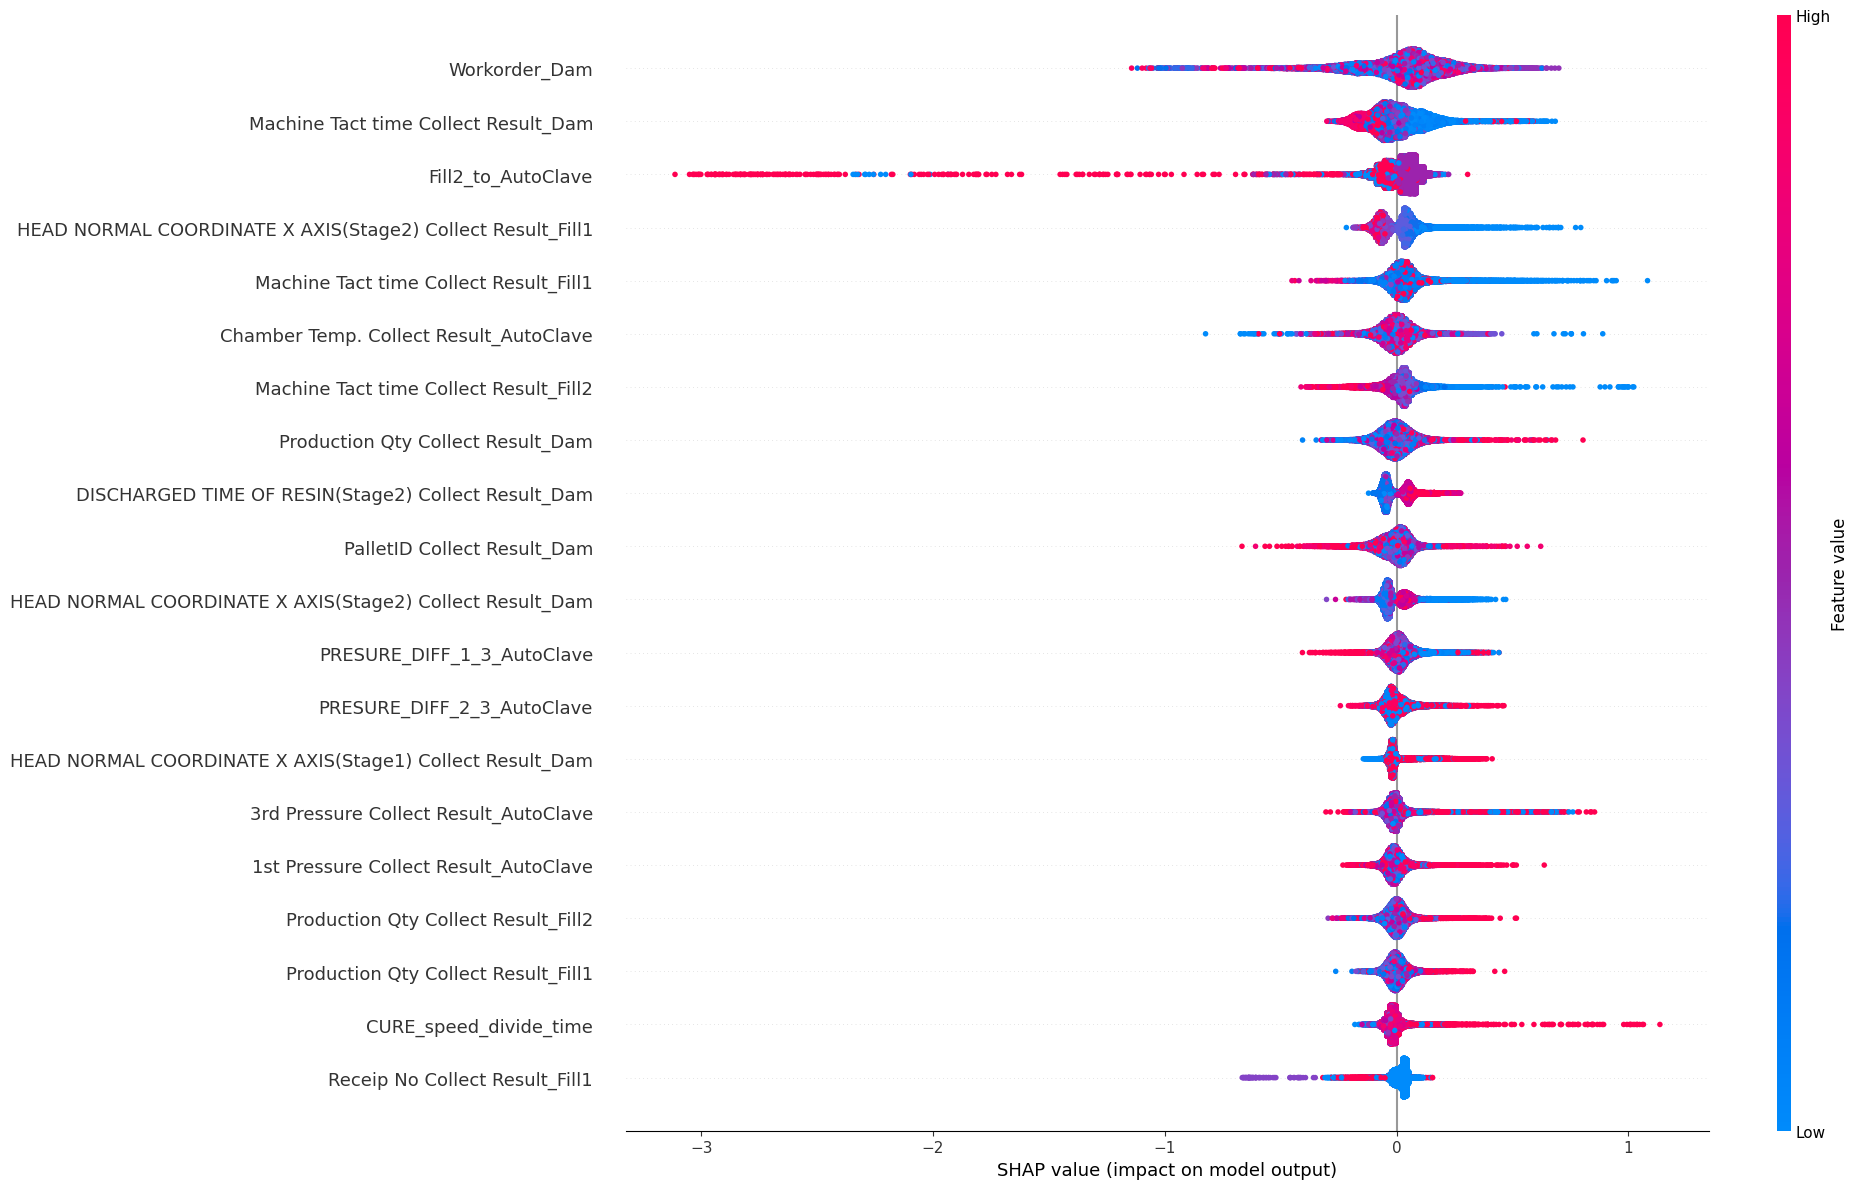

In [61]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)


shap.summary_plot(shap_values, train_x, show=False, plot_size=(20, 12))
plt.show()

In [62]:
# SHAP 값 계산 (이미 수행된 부분)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)

# 특성별 SHAP 값의 평균 절대값 계산
shap_importance = np.abs(shap_values).mean(axis=0)

# 결과를 데이터프레임으로 변환 (특성 중요도 및 SHAP 값)
shap_importance_df = pd.DataFrame({
    'Feature': train_x.columns,
    'Mean |SHAP|': shap_importance
})

# 중요도 순으로 정렬
shap_importance_df = shap_importance_df.sort_values(by='Mean |SHAP|', ascending=False)

# 상위 10개의 중요 특성 출력
print(shap_importance_df.head(10))

# 전체 특성 중요도 출력
shap_importance_df


                                               Feature  Mean |SHAP|
2                                        Workorder_Dam     0.131669
31                Machine Tact time Collect Result_Dam     0.086264
109                                 Fill2_to_AutoClave     0.066887
67   HEAD NORMAL COORDINATE X AXIS(Stage2) Collect ...     0.065152
79              Machine Tact time Collect Result_Fill1     0.057007
55              Chamber Temp. Collect Result_AutoClave     0.052744
100             Machine Tact time Collect Result_Fill2     0.052556
33                   Production Qty Collect Result_Dam     0.052237
10   DISCHARGED TIME OF RESIN(Stage2) Collect Resul...     0.051321
32                         PalletID Collect Result_Dam     0.051072


,Feature,Mean |SHAP|
2,Workorder_Dam,0.131669
31,Machine Tact time Collect Result_Dam,0.086264
109,Fill2_to_AutoClave,0.066887
67,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect ...,0.065152
79,Machine Tact time Collect Result_Fill1,0.057007
...,...,...
74,HEAD Standby Position X Collect Result_Fill1,0.000000
75,HEAD Standby Position Y Collect Result_Fill1,0.000000
76,Head Clean Position X Collect Result_Fill1,0.000000
77,Head Clean Position Z Collect Result_Fill1,0.000000


In [63]:
len(shap_importance_df)

110

### feature importance 확인 후 0인 열 제거

In [64]:
# 123개 중 int 다 포함 하고 0.1 cat모델을 fit 하고 난뒤의 importace 그리고 여기서 0인것들 삭제해서 다시함

# black box 모델인데 왜 그 모델의 feature importance 를 사용하는지?
# -> shap 이나 lime 도 써서 가 두가지 이상의 feature selection 지표로 사용하는것 으로 설명력 높이기
feature_importances = model.get_feature_importance(Pool(train_x, label=train_y, cat_features=int_columns_indice))

In [65]:
feature_importance_df = pd.DataFrame({'Feature': train_x.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [66]:
feature_importance_df.head(60)

,Feature,Importance
2,Workorder_Dam,8.333460
33,Production Qty Collect Result_Dam,6.652803
109,Fill2_to_AutoClave,6.078183
55,Chamber Temp. Collect Result_AutoClave,4.884248
79,Machine Tact time Collect Result_Fill1,4.353375
32,PalletID Collect Result_Dam,4.133087
31,Machine Tact time Collect Result_Dam,3.647948
81,Production Qty Collect Result_Fill1,3.224768
105,PRESURE_DIFF_1_3_AutoClave,3.024092
100,Machine Tact time Collect Result_Fill2,2.984035


In [67]:
feature_importance_df.tail(60)

,Feature,Importance
57,Chamber Temp. Judge Value_AutoClave,0.430322
85,CURE END POSITION Z Collect Result_Fill2,0.404676
73,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect ...,0.395832
9,DISCHARGED TIME OF RESIN(Stage1) Collect Resul...,0.355814
6,CURE SPEED Collect Result_Dam,0.350063
42,Stage3 Circle1 Distance Speed Collect Result_Dam,0.349241
43,Stage3 Line1 Distance Speed Collect Result_Dam,0.340446
44,Stage3 Line3 Distance Speed Collect Result_Dam,0.339878
47,THICKNESS 3 Collect Result_Dam,0.336213
38,Stage2 Circle1 Distance Speed Collect Result_Dam,0.324777


In [68]:
zero_importance_features = feature_importance_df[feature_importance_df['Importance'] < 0.01]['Feature'].tolist()

In [69]:
feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0.01]

In [70]:
len(feature_importance_df)

83

In [71]:
len(shap_importance_df)

110

In [72]:
shap_importance_df= shap_importance_df[shap_importance_df['Mean |SHAP|'] >0]
len(shap_importance_df)

85

In [73]:
# feature_importance_df와 shap_importance_df에서 상위 10개의 'Feature' 컬럼 추출
top_10_feature_importance = feature_importance_df['Feature']
top_10_shap_importance = shap_importance_df['Feature']

# 공통된 특성 추출
common_features = top_10_feature_importance[top_10_feature_importance.isin(top_10_shap_importance)]

# 다른 특성 추출
only_in_feature_importance = top_10_feature_importance[~top_10_feature_importance.isin(top_10_shap_importance)]
only_in_shap_importance = top_10_shap_importance[~top_10_shap_importance.isin(top_10_feature_importance)]

# 결과 출력
print("공통된 특성:\n", common_features)
print("\nfeature_importance_df에만 있는 특성:\n", only_in_feature_importance)
print("\nshap_importance_df에만 있는 특성:\n", only_in_shap_importance)


공통된 특성:
 2                                          Workorder_Dam
33                     Production Qty Collect Result_Dam
109                                   Fill2_to_AutoClave
55                Chamber Temp. Collect Result_AutoClave
79                Machine Tact time Collect Result_Fill1
                             ...                        
91     HEAD NORMAL COORDINATE X AXIS(Stage3) Collect ...
78            Head Purge Position Z Collect Result_Fill1
90     HEAD NORMAL COORDINATE X AXIS(Stage2) Collect ...
5                 CURE END POSITION Θ Collect Result_Dam
94     HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect ...
Name: Feature, Length: 83, dtype: object

feature_importance_df에만 있는 특성:
 Series([], Name: Feature, dtype: object)

shap_importance_df에만 있는 특성:
 84      CURE END POSITION X Collect Result_Fill2
88    CURE START POSITION X Collect Result_Fill2
Name: Feature, dtype: object


In [74]:
common_features

2                                          Workorder_Dam
33                     Production Qty Collect Result_Dam
109                                   Fill2_to_AutoClave
55                Chamber Temp. Collect Result_AutoClave
79                Machine Tact time Collect Result_Fill1
                             ...                        
91     HEAD NORMAL COORDINATE X AXIS(Stage3) Collect ...
78            Head Purge Position Z Collect Result_Fill1
90     HEAD NORMAL COORDINATE X AXIS(Stage2) Collect ...
5                 CURE END POSITION Θ Collect Result_Dam
94     HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect ...
Name: Feature, Length: 83, dtype: object

In [75]:
zero_importance_features

['CURE START POSITION X Collect Result_Fill2',
 'CURE END POSITION X Collect Result_Fill2',
 'HEAD Standby Position X Collect Result_Fill2',
 'HEAD Standby Position Z Collect Result_Fill2',
 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
 'Head Clean Position X Collect Result_Fill2',
 'Head Clean Position Z Collect Result_Fill2',
 'Head Purge Position Z Collect Result_Fill2',
 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
 'CURE END POSITION Z Collect Result_Dam',
 'Equipment_Fill2',
 'Head Zero Position Z Collect Result_Dam',
 'CURE START POSITION X Collect Result_Dam',
 'HEAD Standby Position X Collect Result_Dam',
 'HEAD Standby Position Y Collect Result_Dam',
 'HEAD Standby Position Z Collect Result_Dam',
 'Head Clean Position X Collect Result_Dam',
 'Head Zero Position X Collect Result_Dam',
 'CURE END POSITION X Collect Result_Dam',
 'Head Clean Position Z Collect Result_Fill1',
 'WorkMode Collect Result_Dam',
 'Equipment_Fill1',
 'DISCHARGED SPEED 

In [76]:
train_x = train_x[common_features]
train_x

,Workorder_Dam,Production Qty Collect Result_Dam,Fill2_to_AutoClave,Chamber Temp. Collect Result_AutoClave,Machine Tact time Collect Result_Fill1,PalletID Collect Result_Dam,Machine Tact time Collect Result_Dam,Production Qty Collect Result_Fill1,PRESURE_DIFF_1_3_AutoClave,Machine Tact time Collect Result_Fill2,...,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,Head Zero Position Y Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,CURE END POSITION Θ Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2
0,658,127,30,54,55.7,7,58.5,127,0.187,19.9,...,384.0,300.0,430.3,835.5,430.0,156.0,128.0,458.0,-90,243.7
1,284,185,30,54,56.5,7,65.1,185,0.187,19.6,...,377.3,300.0,430.8,835.5,430.5,156.0,145.0,458.0,-90,243.7
2,590,73,40,56,58.7,10,76.9,73,0.183,19.8,...,1271.8,300.0,1323.1,305.0,1323.5,694.0,128.0,499.8,90,243.5
3,252,268,40,54,57.7,12,70.5,268,0.201,19.9,...,1271.8,300.0,1322.8,305.0,1323.2,694.0,145.0,499.8,90,243.5
4,143,121,40,47,89.9,8,88.3,121,0.196,19.7,...,377.5,300.0,430.5,835.5,430.2,156.0,85.0,458.0,-90,243.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,239,318,40,54,51.8,1,56.7,318,0.200,19.2,...,377.3,300.0,430.8,835.5,430.5,156.0,145.0,458.0,-90,243.7
40502,644,197,40,49,58.7,14,78.5,197,0.193,20.5,...,1281.2,300.0,1324.3,304.8,1325.0,692.8,128.0,499.8,90,243.5
40503,541,27,30,48,56.2,1,69.5,27,0.189,19.7,...,378.0,300.0,431.1,835.5,430.8,156.0,128.0,458.0,-90,243.7
40504,165,117,40,54,57.4,13,57.7,117,0.197,20.1,...,1269.0,300.0,1322.8,305.0,1323.2,694.0,145.0,499.8,90,243.5


### 모델 재정의

In [77]:
int_columns_indices = [index for index, dtype in enumerate(train_x.dtypes) if dtype == 'int64']

In [78]:
# for index in int_columns_indices:
#     column_name = train_x.columns[index]
#     train_x[column_name] = train_x[column_name].astype('category')

In [79]:
# int_columns_indices = [index for index, dtype in enumerate(train_x.dtypes) if dtype == 'int64' or dtype=='category']


In [80]:
# columns_to_encode = [
# #     'Equipment_Dam',
#     'Model.Suffix_Dam',
#     'Workorder_Dam',
#     'Chamber Temp. Judge Value_AutoClave',
#     'Equipment_Fill1',
#     'Equipment_Fill2',
# ]

In [81]:
model = CatBoostClassifier(cat_features =int_columns_indices, random_state=RANDOM_STATE, scale_pos_weight = 0.11) # 왜 0.11 인지

In [82]:
model_knn = KNeighborsClassifier(n_neighbors=9,  metric='cosine') # 9로 왜 했는지, 왜 metric 코사인인지

In [83]:
model_hist =  HistGradientBoostingClassifier(random_state=RANDOM_STATE) # 모델 왜 사용한지

In [84]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=RANDOM_STATE) 
# 왜 6개 폴드인지, 시간 데이터가 있으니깐 그걸로 정렬해서 시간순으로 적용해볼 수 있지 않을까

In [85]:
f1_macro_scores = []

for train_idx, valid_idx in skf.split(train_x, train_y):
    train_data = train_x.iloc[train_idx]
    train_labels = train_y.iloc[train_idx]

    valid_data = train_x.iloc[valid_idx]
    valid_labels = train_y.iloc[valid_idx]

    model.fit(train_data,train_labels) # eval_set=[(valid_data, valid_labels )], early_stopping_rounds=100)
    model_knn.fit(train_data,train_labels)
    model_hist.fit(train_data, train_labels)
    
    predictions = model.predict(valid_data.fillna(0))

    f1_macro = f1_score(valid_labels, predictions, average='macro')
    f1_macro_scores.append(f1_macro)
    

average_f1_macro = np.mean(f1_macro_scores)

print("Average F1-macro score:", average_f1_macro)
print(f1_macro_scores)
    
# 각 fold fit 하고 validation 으로 예측 하고 지표로 평가하는 거 추가해야함, f1 score, recall,

Learning rate set to 0.046294
0:	learn: 0.6836468	total: 111ms	remaining: 1m 51s
1:	learn: 0.6753592	total: 212ms	remaining: 1m 45s
2:	learn: 0.6677824	total: 325ms	remaining: 1m 47s
3:	learn: 0.6608162	total: 429ms	remaining: 1m 46s
4:	learn: 0.6547733	total: 526ms	remaining: 1m 44s
5:	learn: 0.6489394	total: 631ms	remaining: 1m 44s
6:	learn: 0.6439370	total: 745ms	remaining: 1m 45s
7:	learn: 0.6386998	total: 858ms	remaining: 1m 46s
8:	learn: 0.6339643	total: 983ms	remaining: 1m 48s
9:	learn: 0.6296510	total: 1.1s	remaining: 1m 48s
10:	learn: 0.6258170	total: 1.21s	remaining: 1m 48s
11:	learn: 0.6221085	total: 1.31s	remaining: 1m 48s
12:	learn: 0.6189572	total: 1.43s	remaining: 1m 48s
13:	learn: 0.6160012	total: 1.54s	remaining: 1m 48s
14:	learn: 0.6136256	total: 1.65s	remaining: 1m 48s
15:	learn: 0.6112336	total: 1.76s	remaining: 1m 48s
16:	learn: 0.6090724	total: 1.88s	remaining: 1m 48s
17:	learn: 0.6068685	total: 1.99s	remaining: 1m 48s
18:	learn: 0.6048524	total: 2.1s	remaining: 1

157:	learn: 0.5427208	total: 17.6s	remaining: 1m 33s
158:	learn: 0.5422730	total: 17.7s	remaining: 1m 33s
159:	learn: 0.5418829	total: 17.8s	remaining: 1m 33s
160:	learn: 0.5414405	total: 17.9s	remaining: 1m 33s
161:	learn: 0.5410200	total: 18.1s	remaining: 1m 33s
162:	learn: 0.5405550	total: 18.2s	remaining: 1m 33s
163:	learn: 0.5403652	total: 18.3s	remaining: 1m 33s
164:	learn: 0.5402501	total: 18.4s	remaining: 1m 33s
165:	learn: 0.5401136	total: 18.5s	remaining: 1m 33s
166:	learn: 0.5398697	total: 18.6s	remaining: 1m 32s
167:	learn: 0.5394962	total: 18.7s	remaining: 1m 32s
168:	learn: 0.5393586	total: 18.9s	remaining: 1m 32s
169:	learn: 0.5392953	total: 19s	remaining: 1m 32s
170:	learn: 0.5391550	total: 19.1s	remaining: 1m 32s
171:	learn: 0.5389741	total: 19.2s	remaining: 1m 32s
172:	learn: 0.5385688	total: 19.3s	remaining: 1m 32s
173:	learn: 0.5381807	total: 19.4s	remaining: 1m 32s
174:	learn: 0.5378066	total: 19.5s	remaining: 1m 32s
175:	learn: 0.5374168	total: 19.6s	remaining: 1m

315:	learn: 0.5016773	total: 35.2s	remaining: 1m 16s
316:	learn: 0.5014746	total: 35.4s	remaining: 1m 16s
317:	learn: 0.5013552	total: 35.5s	remaining: 1m 16s
318:	learn: 0.5009814	total: 35.6s	remaining: 1m 15s
319:	learn: 0.5007270	total: 35.7s	remaining: 1m 15s
320:	learn: 0.5005156	total: 35.8s	remaining: 1m 15s
321:	learn: 0.5002499	total: 35.9s	remaining: 1m 15s
322:	learn: 0.5000240	total: 36s	remaining: 1m 15s
323:	learn: 0.4998601	total: 36.2s	remaining: 1m 15s
324:	learn: 0.4996323	total: 36.3s	remaining: 1m 15s
325:	learn: 0.4994533	total: 36.4s	remaining: 1m 15s
326:	learn: 0.4991654	total: 36.5s	remaining: 1m 15s
327:	learn: 0.4990408	total: 36.6s	remaining: 1m 14s
328:	learn: 0.4989195	total: 36.7s	remaining: 1m 14s
329:	learn: 0.4988463	total: 36.8s	remaining: 1m 14s
330:	learn: 0.4985213	total: 36.9s	remaining: 1m 14s
331:	learn: 0.4983637	total: 37s	remaining: 1m 14s
332:	learn: 0.4980497	total: 37.1s	remaining: 1m 14s
333:	learn: 0.4978258	total: 37.2s	remaining: 1m 1

473:	learn: 0.4659729	total: 53.2s	remaining: 59s
474:	learn: 0.4656548	total: 53.3s	remaining: 58.9s
475:	learn: 0.4652772	total: 53.4s	remaining: 58.8s
476:	learn: 0.4650810	total: 53.5s	remaining: 58.7s
477:	learn: 0.4649515	total: 53.6s	remaining: 58.5s
478:	learn: 0.4647232	total: 53.7s	remaining: 58.4s
479:	learn: 0.4644968	total: 53.8s	remaining: 58.3s
480:	learn: 0.4644006	total: 53.9s	remaining: 58.2s
481:	learn: 0.4642055	total: 54s	remaining: 58.1s
482:	learn: 0.4639099	total: 54.1s	remaining: 58s
483:	learn: 0.4638233	total: 54.3s	remaining: 57.8s
484:	learn: 0.4636013	total: 54.4s	remaining: 57.7s
485:	learn: 0.4634814	total: 54.5s	remaining: 57.6s
486:	learn: 0.4632586	total: 54.6s	remaining: 57.5s
487:	learn: 0.4629290	total: 54.7s	remaining: 57.4s
488:	learn: 0.4626649	total: 54.8s	remaining: 57.3s
489:	learn: 0.4624153	total: 55s	remaining: 57.2s
490:	learn: 0.4623489	total: 55.1s	remaining: 57.1s
491:	learn: 0.4620732	total: 55.2s	remaining: 57s
492:	learn: 0.4618313	

632:	learn: 0.4328545	total: 1m 11s	remaining: 41.3s
633:	learn: 0.4327479	total: 1m 11s	remaining: 41.2s
634:	learn: 0.4326337	total: 1m 11s	remaining: 41.1s
635:	learn: 0.4325527	total: 1m 11s	remaining: 41s
636:	learn: 0.4324190	total: 1m 11s	remaining: 40.9s
637:	learn: 0.4322130	total: 1m 11s	remaining: 40.8s
638:	learn: 0.4320379	total: 1m 11s	remaining: 40.6s
639:	learn: 0.4316632	total: 1m 12s	remaining: 40.5s
640:	learn: 0.4316022	total: 1m 12s	remaining: 40.4s
641:	learn: 0.4314210	total: 1m 12s	remaining: 40.3s
642:	learn: 0.4312950	total: 1m 12s	remaining: 40.2s
643:	learn: 0.4310743	total: 1m 12s	remaining: 40.1s
644:	learn: 0.4308938	total: 1m 12s	remaining: 40s
645:	learn: 0.4305174	total: 1m 12s	remaining: 39.9s
646:	learn: 0.4304016	total: 1m 12s	remaining: 39.8s
647:	learn: 0.4301968	total: 1m 12s	remaining: 39.6s
648:	learn: 0.4298700	total: 1m 13s	remaining: 39.5s
649:	learn: 0.4297558	total: 1m 13s	remaining: 39.4s
650:	learn: 0.4296052	total: 1m 13s	remaining: 39.

789:	learn: 0.4047130	total: 1m 29s	remaining: 23.8s
790:	learn: 0.4045213	total: 1m 29s	remaining: 23.7s
791:	learn: 0.4043322	total: 1m 29s	remaining: 23.6s
792:	learn: 0.4042455	total: 1m 29s	remaining: 23.4s
793:	learn: 0.4040141	total: 1m 29s	remaining: 23.3s
794:	learn: 0.4037887	total: 1m 30s	remaining: 23.2s
795:	learn: 0.4035117	total: 1m 30s	remaining: 23.1s
796:	learn: 0.4034006	total: 1m 30s	remaining: 23s
797:	learn: 0.4033360	total: 1m 30s	remaining: 22.9s
798:	learn: 0.4031545	total: 1m 30s	remaining: 22.8s
799:	learn: 0.4030044	total: 1m 30s	remaining: 22.7s
800:	learn: 0.4028685	total: 1m 30s	remaining: 22.6s
801:	learn: 0.4026565	total: 1m 30s	remaining: 22.4s
802:	learn: 0.4025874	total: 1m 30s	remaining: 22.3s
803:	learn: 0.4023905	total: 1m 31s	remaining: 22.2s
804:	learn: 0.4023379	total: 1m 31s	remaining: 22.1s
805:	learn: 0.4022633	total: 1m 31s	remaining: 22s
806:	learn: 0.4019947	total: 1m 31s	remaining: 21.9s
807:	learn: 0.4016531	total: 1m 31s	remaining: 21.

945:	learn: 0.3780236	total: 1m 47s	remaining: 6.13s
946:	learn: 0.3779559	total: 1m 47s	remaining: 6.01s
947:	learn: 0.3777567	total: 1m 47s	remaining: 5.9s
948:	learn: 0.3776836	total: 1m 47s	remaining: 5.79s
949:	learn: 0.3776145	total: 1m 47s	remaining: 5.67s
950:	learn: 0.3774265	total: 1m 47s	remaining: 5.56s
951:	learn: 0.3771585	total: 1m 48s	remaining: 5.45s
952:	learn: 0.3770395	total: 1m 48s	remaining: 5.34s
953:	learn: 0.3769495	total: 1m 48s	remaining: 5.22s
954:	learn: 0.3767344	total: 1m 48s	remaining: 5.11s
955:	learn: 0.3765982	total: 1m 48s	remaining: 5s
956:	learn: 0.3764547	total: 1m 48s	remaining: 4.88s
957:	learn: 0.3762443	total: 1m 48s	remaining: 4.77s
958:	learn: 0.3761057	total: 1m 48s	remaining: 4.66s
959:	learn: 0.3759080	total: 1m 49s	remaining: 4.54s
960:	learn: 0.3757641	total: 1m 49s	remaining: 4.43s
961:	learn: 0.3755649	total: 1m 49s	remaining: 4.32s
962:	learn: 0.3754434	total: 1m 49s	remaining: 4.2s
963:	learn: 0.3752518	total: 1m 49s	remaining: 4.09

103:	learn: 0.5548257	total: 11.6s	remaining: 1m 39s
104:	learn: 0.5544666	total: 11.7s	remaining: 1m 39s
105:	learn: 0.5541030	total: 11.8s	remaining: 1m 39s
106:	learn: 0.5539687	total: 11.9s	remaining: 1m 39s
107:	learn: 0.5536382	total: 12s	remaining: 1m 39s
108:	learn: 0.5533748	total: 12.1s	remaining: 1m 39s
109:	learn: 0.5531839	total: 12.3s	remaining: 1m 39s
110:	learn: 0.5530762	total: 12.4s	remaining: 1m 39s
111:	learn: 0.5526934	total: 12.5s	remaining: 1m 38s
112:	learn: 0.5524490	total: 12.6s	remaining: 1m 38s
113:	learn: 0.5521515	total: 12.7s	remaining: 1m 38s
114:	learn: 0.5517576	total: 12.8s	remaining: 1m 38s
115:	learn: 0.5515973	total: 12.9s	remaining: 1m 38s
116:	learn: 0.5513588	total: 13s	remaining: 1m 38s
117:	learn: 0.5510945	total: 13.2s	remaining: 1m 38s
118:	learn: 0.5507683	total: 13.3s	remaining: 1m 38s
119:	learn: 0.5505971	total: 13.4s	remaining: 1m 38s
120:	learn: 0.5502562	total: 13.5s	remaining: 1m 37s
121:	learn: 0.5499993	total: 13.6s	remaining: 1m 3

260:	learn: 0.5143490	total: 29.3s	remaining: 1m 23s
261:	learn: 0.5142304	total: 29.4s	remaining: 1m 22s
262:	learn: 0.5139968	total: 29.6s	remaining: 1m 22s
263:	learn: 0.5137215	total: 29.7s	remaining: 1m 22s
264:	learn: 0.5134976	total: 29.8s	remaining: 1m 22s
265:	learn: 0.5131099	total: 29.9s	remaining: 1m 22s
266:	learn: 0.5128706	total: 30s	remaining: 1m 22s
267:	learn: 0.5126595	total: 30.1s	remaining: 1m 22s
268:	learn: 0.5124543	total: 30.3s	remaining: 1m 22s
269:	learn: 0.5121500	total: 30.4s	remaining: 1m 22s
270:	learn: 0.5117252	total: 30.5s	remaining: 1m 22s
271:	learn: 0.5113288	total: 30.6s	remaining: 1m 21s
272:	learn: 0.5109166	total: 30.7s	remaining: 1m 21s
273:	learn: 0.5106694	total: 30.9s	remaining: 1m 21s
274:	learn: 0.5103558	total: 31s	remaining: 1m 21s
275:	learn: 0.5100932	total: 31.1s	remaining: 1m 21s
276:	learn: 0.5099829	total: 31.2s	remaining: 1m 21s
277:	learn: 0.5096614	total: 31.3s	remaining: 1m 21s
278:	learn: 0.5092706	total: 31.4s	remaining: 1m 2

416:	learn: 0.4756390	total: 47s	remaining: 1m 5s
417:	learn: 0.4754976	total: 47.1s	remaining: 1m 5s
418:	learn: 0.4753244	total: 47.2s	remaining: 1m 5s
419:	learn: 0.4752533	total: 47.3s	remaining: 1m 5s
420:	learn: 0.4751532	total: 47.4s	remaining: 1m 5s
421:	learn: 0.4748925	total: 47.5s	remaining: 1m 5s
422:	learn: 0.4746607	total: 47.6s	remaining: 1m 4s
423:	learn: 0.4745556	total: 47.7s	remaining: 1m 4s
424:	learn: 0.4742000	total: 47.8s	remaining: 1m 4s
425:	learn: 0.4740235	total: 47.9s	remaining: 1m 4s
426:	learn: 0.4738367	total: 48.1s	remaining: 1m 4s
427:	learn: 0.4736132	total: 48.2s	remaining: 1m 4s
428:	learn: 0.4731771	total: 48.3s	remaining: 1m 4s
429:	learn: 0.4730272	total: 48.4s	remaining: 1m 4s
430:	learn: 0.4727679	total: 48.5s	remaining: 1m 4s
431:	learn: 0.4725236	total: 48.7s	remaining: 1m 3s
432:	learn: 0.4724254	total: 48.8s	remaining: 1m 3s
433:	learn: 0.4722358	total: 48.9s	remaining: 1m 3s
434:	learn: 0.4720937	total: 49s	remaining: 1m 3s
435:	learn: 0.47

576:	learn: 0.4432960	total: 1m 4s	remaining: 47.6s
577:	learn: 0.4430100	total: 1m 4s	remaining: 47.5s
578:	learn: 0.4429740	total: 1m 5s	remaining: 47.3s
579:	learn: 0.4426516	total: 1m 5s	remaining: 47.2s
580:	learn: 0.4424935	total: 1m 5s	remaining: 47.1s
581:	learn: 0.4421776	total: 1m 5s	remaining: 47s
582:	learn: 0.4419763	total: 1m 5s	remaining: 46.9s
583:	learn: 0.4415980	total: 1m 5s	remaining: 46.8s
584:	learn: 0.4413541	total: 1m 5s	remaining: 46.7s
585:	learn: 0.4411626	total: 1m 5s	remaining: 46.5s
586:	learn: 0.4408834	total: 1m 5s	remaining: 46.4s
587:	learn: 0.4406385	total: 1m 6s	remaining: 46.3s
588:	learn: 0.4402386	total: 1m 6s	remaining: 46.2s
589:	learn: 0.4400330	total: 1m 6s	remaining: 46.1s
590:	learn: 0.4397832	total: 1m 6s	remaining: 46s
591:	learn: 0.4396532	total: 1m 6s	remaining: 45.9s
592:	learn: 0.4394518	total: 1m 6s	remaining: 45.7s
593:	learn: 0.4394022	total: 1m 6s	remaining: 45.6s
594:	learn: 0.4393167	total: 1m 6s	remaining: 45.5s
595:	learn: 0.43

733:	learn: 0.4146000	total: 1m 22s	remaining: 29.9s
734:	learn: 0.4144435	total: 1m 22s	remaining: 29.8s
735:	learn: 0.4140781	total: 1m 22s	remaining: 29.7s
736:	learn: 0.4138576	total: 1m 22s	remaining: 29.6s
737:	learn: 0.4137334	total: 1m 23s	remaining: 29.5s
738:	learn: 0.4134971	total: 1m 23s	remaining: 29.4s
739:	learn: 0.4134185	total: 1m 23s	remaining: 29.3s
740:	learn: 0.4133798	total: 1m 23s	remaining: 29.2s
741:	learn: 0.4131895	total: 1m 23s	remaining: 29.1s
742:	learn: 0.4129209	total: 1m 23s	remaining: 28.9s
743:	learn: 0.4127687	total: 1m 23s	remaining: 28.8s
744:	learn: 0.4126230	total: 1m 23s	remaining: 28.7s
745:	learn: 0.4122982	total: 1m 23s	remaining: 28.6s
746:	learn: 0.4120773	total: 1m 24s	remaining: 28.5s
747:	learn: 0.4119302	total: 1m 24s	remaining: 28.4s
748:	learn: 0.4116653	total: 1m 24s	remaining: 28.3s
749:	learn: 0.4114448	total: 1m 24s	remaining: 28.2s
750:	learn: 0.4113467	total: 1m 24s	remaining: 28s
751:	learn: 0.4111155	total: 1m 24s	remaining: 2

890:	learn: 0.3897452	total: 1m 40s	remaining: 12.3s
891:	learn: 0.3894569	total: 1m 40s	remaining: 12.2s
892:	learn: 0.3891704	total: 1m 40s	remaining: 12.1s
893:	learn: 0.3890154	total: 1m 40s	remaining: 12s
894:	learn: 0.3888515	total: 1m 40s	remaining: 11.8s
895:	learn: 0.3887689	total: 1m 41s	remaining: 11.7s
896:	learn: 0.3886782	total: 1m 41s	remaining: 11.6s
897:	learn: 0.3884439	total: 1m 41s	remaining: 11.5s
898:	learn: 0.3883458	total: 1m 41s	remaining: 11.4s
899:	learn: 0.3882029	total: 1m 41s	remaining: 11.3s
900:	learn: 0.3879464	total: 1m 41s	remaining: 11.2s
901:	learn: 0.3878641	total: 1m 41s	remaining: 11.1s
902:	learn: 0.3876201	total: 1m 41s	remaining: 10.9s
903:	learn: 0.3875956	total: 1m 42s	remaining: 10.8s
904:	learn: 0.3874250	total: 1m 42s	remaining: 10.7s
905:	learn: 0.3872655	total: 1m 42s	remaining: 10.6s
906:	learn: 0.3870597	total: 1m 42s	remaining: 10.5s
907:	learn: 0.3869310	total: 1m 42s	remaining: 10.4s
908:	learn: 0.3865758	total: 1m 42s	remaining: 1

47:	learn: 0.5784406	total: 5.26s	remaining: 1m 44s
48:	learn: 0.5778866	total: 5.37s	remaining: 1m 44s
49:	learn: 0.5775849	total: 5.49s	remaining: 1m 44s
50:	learn: 0.5770581	total: 5.6s	remaining: 1m 44s
51:	learn: 0.5763340	total: 5.71s	remaining: 1m 44s
52:	learn: 0.5757258	total: 5.82s	remaining: 1m 43s
53:	learn: 0.5753059	total: 5.93s	remaining: 1m 43s
54:	learn: 0.5747679	total: 6.04s	remaining: 1m 43s
55:	learn: 0.5743380	total: 6.15s	remaining: 1m 43s
56:	learn: 0.5737866	total: 6.25s	remaining: 1m 43s
57:	learn: 0.5731364	total: 6.35s	remaining: 1m 43s
58:	learn: 0.5725886	total: 6.44s	remaining: 1m 42s
59:	learn: 0.5722880	total: 6.54s	remaining: 1m 42s
60:	learn: 0.5718639	total: 6.63s	remaining: 1m 42s
61:	learn: 0.5711894	total: 6.75s	remaining: 1m 42s
62:	learn: 0.5704642	total: 6.85s	remaining: 1m 41s
63:	learn: 0.5697400	total: 6.96s	remaining: 1m 41s
64:	learn: 0.5692094	total: 7.08s	remaining: 1m 41s
65:	learn: 0.5688604	total: 7.19s	remaining: 1m 41s
66:	learn: 0.

204:	learn: 0.5287902	total: 22.8s	remaining: 1m 28s
205:	learn: 0.5286239	total: 22.9s	remaining: 1m 28s
206:	learn: 0.5285147	total: 23s	remaining: 1m 28s
207:	learn: 0.5283371	total: 23.1s	remaining: 1m 27s
208:	learn: 0.5280345	total: 23.2s	remaining: 1m 27s
209:	learn: 0.5275759	total: 23.3s	remaining: 1m 27s
210:	learn: 0.5273848	total: 23.5s	remaining: 1m 27s
211:	learn: 0.5272479	total: 23.6s	remaining: 1m 27s
212:	learn: 0.5269317	total: 23.7s	remaining: 1m 27s
213:	learn: 0.5265093	total: 23.8s	remaining: 1m 27s
214:	learn: 0.5262231	total: 23.9s	remaining: 1m 27s
215:	learn: 0.5259002	total: 24.1s	remaining: 1m 27s
216:	learn: 0.5256766	total: 24.2s	remaining: 1m 27s
217:	learn: 0.5254260	total: 24.3s	remaining: 1m 27s
218:	learn: 0.5251958	total: 24.4s	remaining: 1m 27s
219:	learn: 0.5248940	total: 24.5s	remaining: 1m 26s
220:	learn: 0.5247601	total: 24.6s	remaining: 1m 26s
221:	learn: 0.5244187	total: 24.7s	remaining: 1m 26s
222:	learn: 0.5240593	total: 24.9s	remaining: 1m

360:	learn: 0.4879043	total: 40.7s	remaining: 1m 12s
361:	learn: 0.4875709	total: 40.9s	remaining: 1m 11s
362:	learn: 0.4873461	total: 41s	remaining: 1m 11s
363:	learn: 0.4870670	total: 41.1s	remaining: 1m 11s
364:	learn: 0.4866066	total: 41.2s	remaining: 1m 11s
365:	learn: 0.4863417	total: 41.3s	remaining: 1m 11s
366:	learn: 0.4860699	total: 41.4s	remaining: 1m 11s
367:	learn: 0.4857146	total: 41.5s	remaining: 1m 11s
368:	learn: 0.4855016	total: 41.6s	remaining: 1m 11s
369:	learn: 0.4852488	total: 41.7s	remaining: 1m 11s
370:	learn: 0.4849748	total: 41.9s	remaining: 1m 10s
371:	learn: 0.4846388	total: 42s	remaining: 1m 10s
372:	learn: 0.4841944	total: 42.1s	remaining: 1m 10s
373:	learn: 0.4839333	total: 42.2s	remaining: 1m 10s
374:	learn: 0.4836897	total: 42.3s	remaining: 1m 10s
375:	learn: 0.4836423	total: 42.5s	remaining: 1m 10s
376:	learn: 0.4834691	total: 42.6s	remaining: 1m 10s
377:	learn: 0.4832370	total: 42.7s	remaining: 1m 10s
378:	learn: 0.4831509	total: 42.8s	remaining: 1m 1

519:	learn: 0.4511323	total: 59s	remaining: 54.5s
520:	learn: 0.4508316	total: 59.1s	remaining: 54.4s
521:	learn: 0.4504554	total: 59.3s	remaining: 54.3s
522:	learn: 0.4501501	total: 59.4s	remaining: 54.2s
523:	learn: 0.4499337	total: 59.5s	remaining: 54s
524:	learn: 0.4497718	total: 59.6s	remaining: 53.9s
525:	learn: 0.4496196	total: 59.7s	remaining: 53.8s
526:	learn: 0.4494916	total: 59.8s	remaining: 53.7s
527:	learn: 0.4493660	total: 59.9s	remaining: 53.6s
528:	learn: 0.4492485	total: 1m	remaining: 53.5s
529:	learn: 0.4488997	total: 1m	remaining: 53.4s
530:	learn: 0.4486538	total: 1m	remaining: 53.2s
531:	learn: 0.4485189	total: 1m	remaining: 53.1s
532:	learn: 0.4483355	total: 1m	remaining: 53s
533:	learn: 0.4482297	total: 1m	remaining: 52.9s
534:	learn: 0.4480390	total: 1m	remaining: 52.8s
535:	learn: 0.4478538	total: 1m	remaining: 52.7s
536:	learn: 0.4477041	total: 1m	remaining: 52.6s
537:	learn: 0.4474142	total: 1m 1s	remaining: 52.5s
538:	learn: 0.4471926	total: 1m 1s	remaining:

678:	learn: 0.4187375	total: 1m 17s	remaining: 36.5s
679:	learn: 0.4185376	total: 1m 17s	remaining: 36.4s
680:	learn: 0.4183664	total: 1m 17s	remaining: 36.3s
681:	learn: 0.4181034	total: 1m 17s	remaining: 36.2s
682:	learn: 0.4179553	total: 1m 17s	remaining: 36.1s
683:	learn: 0.4177019	total: 1m 17s	remaining: 36s
684:	learn: 0.4175516	total: 1m 17s	remaining: 35.9s
685:	learn: 0.4174431	total: 1m 18s	remaining: 35.8s
686:	learn: 0.4172369	total: 1m 18s	remaining: 35.6s
687:	learn: 0.4169983	total: 1m 18s	remaining: 35.5s
688:	learn: 0.4168799	total: 1m 18s	remaining: 35.4s
689:	learn: 0.4167622	total: 1m 18s	remaining: 35.3s
690:	learn: 0.4164776	total: 1m 18s	remaining: 35.2s
691:	learn: 0.4162492	total: 1m 18s	remaining: 35s
692:	learn: 0.4161521	total: 1m 18s	remaining: 34.9s
693:	learn: 0.4159886	total: 1m 18s	remaining: 34.8s
694:	learn: 0.4158319	total: 1m 19s	remaining: 34.7s
695:	learn: 0.4156588	total: 1m 19s	remaining: 34.6s
696:	learn: 0.4153877	total: 1m 19s	remaining: 34.

835:	learn: 0.3900009	total: 1m 35s	remaining: 18.7s
836:	learn: 0.3897178	total: 1m 35s	remaining: 18.6s
837:	learn: 0.3896707	total: 1m 35s	remaining: 18.5s
838:	learn: 0.3893393	total: 1m 35s	remaining: 18.4s
839:	learn: 0.3892624	total: 1m 35s	remaining: 18.2s
840:	learn: 0.3890882	total: 1m 35s	remaining: 18.1s
841:	learn: 0.3887717	total: 1m 36s	remaining: 18s
842:	learn: 0.3886625	total: 1m 36s	remaining: 17.9s
843:	learn: 0.3884517	total: 1m 36s	remaining: 17.8s
844:	learn: 0.3884219	total: 1m 36s	remaining: 17.7s
845:	learn: 0.3882680	total: 1m 36s	remaining: 17.6s
846:	learn: 0.3880543	total: 1m 36s	remaining: 17.4s
847:	learn: 0.3878388	total: 1m 36s	remaining: 17.3s
848:	learn: 0.3875912	total: 1m 36s	remaining: 17.2s
849:	learn: 0.3873828	total: 1m 36s	remaining: 17.1s
850:	learn: 0.3872640	total: 1m 37s	remaining: 17s
851:	learn: 0.3871130	total: 1m 37s	remaining: 16.9s
852:	learn: 0.3869646	total: 1m 37s	remaining: 16.8s
853:	learn: 0.3866355	total: 1m 37s	remaining: 16.

991:	learn: 0.3632113	total: 1m 53s	remaining: 915ms
992:	learn: 0.3630199	total: 1m 53s	remaining: 801ms
993:	learn: 0.3628470	total: 1m 53s	remaining: 686ms
994:	learn: 0.3627387	total: 1m 53s	remaining: 572ms
995:	learn: 0.3626041	total: 1m 53s	remaining: 458ms
996:	learn: 0.3625070	total: 1m 54s	remaining: 343ms
997:	learn: 0.3623773	total: 1m 54s	remaining: 229ms
998:	learn: 0.3623114	total: 1m 54s	remaining: 114ms
999:	learn: 0.3621632	total: 1m 54s	remaining: 0us
Learning rate set to 0.046294
0:	learn: 0.6833038	total: 105ms	remaining: 1m 45s
1:	learn: 0.6750150	total: 209ms	remaining: 1m 44s
2:	learn: 0.6671783	total: 319ms	remaining: 1m 45s
3:	learn: 0.6601091	total: 425ms	remaining: 1m 45s
4:	learn: 0.6535878	total: 535ms	remaining: 1m 46s
5:	learn: 0.6480465	total: 631ms	remaining: 1m 44s
6:	learn: 0.6429983	total: 737ms	remaining: 1m 44s
7:	learn: 0.6387611	total: 838ms	remaining: 1m 43s
8:	learn: 0.6347082	total: 935ms	remaining: 1m 42s
9:	learn: 0.6311060	total: 1.05s	rem

148:	learn: 0.5403185	total: 16.8s	remaining: 1m 35s
149:	learn: 0.5402181	total: 16.9s	remaining: 1m 35s
150:	learn: 0.5400088	total: 17s	remaining: 1m 35s
151:	learn: 0.5398818	total: 17.1s	remaining: 1m 35s
152:	learn: 0.5396753	total: 17.2s	remaining: 1m 35s
153:	learn: 0.5394159	total: 17.3s	remaining: 1m 35s
154:	learn: 0.5392203	total: 17.5s	remaining: 1m 35s
155:	learn: 0.5388248	total: 17.6s	remaining: 1m 35s
156:	learn: 0.5386285	total: 17.7s	remaining: 1m 35s
157:	learn: 0.5382131	total: 17.8s	remaining: 1m 34s
158:	learn: 0.5379595	total: 17.9s	remaining: 1m 34s
159:	learn: 0.5376899	total: 18s	remaining: 1m 34s
160:	learn: 0.5375207	total: 18.2s	remaining: 1m 34s
161:	learn: 0.5373372	total: 18.3s	remaining: 1m 34s
162:	learn: 0.5368484	total: 18.4s	remaining: 1m 34s
163:	learn: 0.5364448	total: 18.5s	remaining: 1m 34s
164:	learn: 0.5361128	total: 18.6s	remaining: 1m 34s
165:	learn: 0.5358584	total: 18.7s	remaining: 1m 34s
166:	learn: 0.5356541	total: 18.8s	remaining: 1m 3

304:	learn: 0.4995335	total: 34.7s	remaining: 1m 19s
305:	learn: 0.4991862	total: 34.8s	remaining: 1m 18s
306:	learn: 0.4989951	total: 34.9s	remaining: 1m 18s
307:	learn: 0.4985620	total: 35s	remaining: 1m 18s
308:	learn: 0.4982663	total: 35.1s	remaining: 1m 18s
309:	learn: 0.4980421	total: 35.3s	remaining: 1m 18s
310:	learn: 0.4976523	total: 35.4s	remaining: 1m 18s
311:	learn: 0.4974743	total: 35.5s	remaining: 1m 18s
312:	learn: 0.4972029	total: 35.6s	remaining: 1m 18s
313:	learn: 0.4970808	total: 35.7s	remaining: 1m 17s
314:	learn: 0.4968015	total: 35.8s	remaining: 1m 17s
315:	learn: 0.4963567	total: 35.9s	remaining: 1m 17s
316:	learn: 0.4962462	total: 36s	remaining: 1m 17s
317:	learn: 0.4961622	total: 36.1s	remaining: 1m 17s
318:	learn: 0.4959067	total: 36.2s	remaining: 1m 17s
319:	learn: 0.4957347	total: 36.3s	remaining: 1m 17s
320:	learn: 0.4954542	total: 36.4s	remaining: 1m 17s
321:	learn: 0.4952378	total: 36.6s	remaining: 1m 16s
322:	learn: 0.4950236	total: 36.6s	remaining: 1m 1

462:	learn: 0.4605100	total: 52.8s	remaining: 1m 1s
463:	learn: 0.4602376	total: 52.9s	remaining: 1m 1s
464:	learn: 0.4599631	total: 53s	remaining: 1m
465:	learn: 0.4598137	total: 53.1s	remaining: 1m
466:	learn: 0.4595651	total: 53.2s	remaining: 1m
467:	learn: 0.4593764	total: 53.3s	remaining: 1m
468:	learn: 0.4591503	total: 53.5s	remaining: 1m
469:	learn: 0.4589888	total: 53.6s	remaining: 1m
470:	learn: 0.4587341	total: 53.7s	remaining: 1m
471:	learn: 0.4584318	total: 53.8s	remaining: 1m
472:	learn: 0.4581672	total: 53.9s	remaining: 1m
473:	learn: 0.4580380	total: 54s	remaining: 60s
474:	learn: 0.4577979	total: 54.2s	remaining: 59.9s
475:	learn: 0.4577205	total: 54.3s	remaining: 59.7s
476:	learn: 0.4575558	total: 54.4s	remaining: 59.6s
477:	learn: 0.4572802	total: 54.5s	remaining: 59.5s
478:	learn: 0.4570516	total: 54.6s	remaining: 59.4s
479:	learn: 0.4568081	total: 54.7s	remaining: 59.3s
480:	learn: 0.4565581	total: 54.8s	remaining: 59.2s
481:	learn: 0.4562696	total: 55s	remaining: 5

623:	learn: 0.4277175	total: 1m 11s	remaining: 43s
624:	learn: 0.4273456	total: 1m 11s	remaining: 42.9s
625:	learn: 0.4270318	total: 1m 11s	remaining: 42.8s
626:	learn: 0.4267228	total: 1m 11s	remaining: 42.7s
627:	learn: 0.4264643	total: 1m 11s	remaining: 42.5s
628:	learn: 0.4263858	total: 1m 11s	remaining: 42.4s
629:	learn: 0.4262003	total: 1m 12s	remaining: 42.3s
630:	learn: 0.4260969	total: 1m 12s	remaining: 42.2s
631:	learn: 0.4257697	total: 1m 12s	remaining: 42.1s
632:	learn: 0.4254508	total: 1m 12s	remaining: 42s
633:	learn: 0.4252001	total: 1m 12s	remaining: 41.9s
634:	learn: 0.4247363	total: 1m 12s	remaining: 41.8s
635:	learn: 0.4245705	total: 1m 12s	remaining: 41.6s
636:	learn: 0.4244822	total: 1m 12s	remaining: 41.5s
637:	learn: 0.4241081	total: 1m 13s	remaining: 41.4s
638:	learn: 0.4239279	total: 1m 13s	remaining: 41.3s
639:	learn: 0.4236066	total: 1m 13s	remaining: 41.2s
640:	learn: 0.4233796	total: 1m 13s	remaining: 41.1s
641:	learn: 0.4232248	total: 1m 13s	remaining: 41s

779:	learn: 0.3974337	total: 1m 29s	remaining: 25.2s
780:	learn: 0.3971995	total: 1m 29s	remaining: 25.1s
781:	learn: 0.3970095	total: 1m 29s	remaining: 25s
782:	learn: 0.3968145	total: 1m 29s	remaining: 24.8s
783:	learn: 0.3965821	total: 1m 29s	remaining: 24.7s
784:	learn: 0.3963903	total: 1m 29s	remaining: 24.6s
785:	learn: 0.3963208	total: 1m 30s	remaining: 24.5s
786:	learn: 0.3962430	total: 1m 30s	remaining: 24.4s
787:	learn: 0.3961772	total: 1m 30s	remaining: 24.3s
788:	learn: 0.3960108	total: 1m 30s	remaining: 24.2s
789:	learn: 0.3957471	total: 1m 30s	remaining: 24s
790:	learn: 0.3955325	total: 1m 30s	remaining: 23.9s
791:	learn: 0.3951669	total: 1m 30s	remaining: 23.8s
792:	learn: 0.3949517	total: 1m 30s	remaining: 23.7s
793:	learn: 0.3948713	total: 1m 30s	remaining: 23.6s
794:	learn: 0.3947457	total: 1m 31s	remaining: 23.5s
795:	learn: 0.3945012	total: 1m 31s	remaining: 23.4s
796:	learn: 0.3942761	total: 1m 31s	remaining: 23.2s
797:	learn: 0.3941187	total: 1m 31s	remaining: 23.

935:	learn: 0.3709573	total: 1m 47s	remaining: 7.33s
936:	learn: 0.3707564	total: 1m 47s	remaining: 7.22s
937:	learn: 0.3706249	total: 1m 47s	remaining: 7.11s
938:	learn: 0.3704548	total: 1m 47s	remaining: 6.99s
939:	learn: 0.3703435	total: 1m 47s	remaining: 6.88s
940:	learn: 0.3701120	total: 1m 47s	remaining: 6.76s
941:	learn: 0.3698504	total: 1m 47s	remaining: 6.65s
942:	learn: 0.3696756	total: 1m 48s	remaining: 6.53s
943:	learn: 0.3694807	total: 1m 48s	remaining: 6.42s
944:	learn: 0.3692371	total: 1m 48s	remaining: 6.3s
945:	learn: 0.3690558	total: 1m 48s	remaining: 6.19s
946:	learn: 0.3689702	total: 1m 48s	remaining: 6.08s
947:	learn: 0.3687726	total: 1m 48s	remaining: 5.96s
948:	learn: 0.3686446	total: 1m 48s	remaining: 5.85s
949:	learn: 0.3683308	total: 1m 48s	remaining: 5.73s
950:	learn: 0.3681345	total: 1m 49s	remaining: 5.62s
951:	learn: 0.3680261	total: 1m 49s	remaining: 5.5s
952:	learn: 0.3678174	total: 1m 49s	remaining: 5.39s
953:	learn: 0.3677101	total: 1m 49s	remaining: 5

93:	learn: 0.5567944	total: 10.4s	remaining: 1m 39s
94:	learn: 0.5564680	total: 10.5s	remaining: 1m 39s
95:	learn: 0.5562146	total: 10.6s	remaining: 1m 39s
96:	learn: 0.5559517	total: 10.7s	remaining: 1m 39s
97:	learn: 0.5556374	total: 10.8s	remaining: 1m 39s
98:	learn: 0.5553031	total: 10.9s	remaining: 1m 39s
99:	learn: 0.5548190	total: 11s	remaining: 1m 39s
100:	learn: 0.5546107	total: 11.1s	remaining: 1m 39s
101:	learn: 0.5542686	total: 11.3s	remaining: 1m 39s
102:	learn: 0.5541076	total: 11.4s	remaining: 1m 38s
103:	learn: 0.5539468	total: 11.5s	remaining: 1m 38s
104:	learn: 0.5535694	total: 11.6s	remaining: 1m 38s
105:	learn: 0.5532687	total: 11.7s	remaining: 1m 38s
106:	learn: 0.5527614	total: 11.8s	remaining: 1m 38s
107:	learn: 0.5524508	total: 11.9s	remaining: 1m 38s
108:	learn: 0.5520723	total: 12s	remaining: 1m 38s
109:	learn: 0.5517338	total: 12.2s	remaining: 1m 38s
110:	learn: 0.5514233	total: 12.2s	remaining: 1m 38s
111:	learn: 0.5509546	total: 12.4s	remaining: 1m 38s
112:

249:	learn: 0.5136776	total: 28s	remaining: 1m 24s
250:	learn: 0.5134457	total: 28.1s	remaining: 1m 23s
251:	learn: 0.5131575	total: 28.3s	remaining: 1m 23s
252:	learn: 0.5130028	total: 28.4s	remaining: 1m 23s
253:	learn: 0.5127726	total: 28.5s	remaining: 1m 23s
254:	learn: 0.5124834	total: 28.6s	remaining: 1m 23s
255:	learn: 0.5120852	total: 28.7s	remaining: 1m 23s
256:	learn: 0.5117422	total: 28.8s	remaining: 1m 23s
257:	learn: 0.5115456	total: 28.9s	remaining: 1m 23s
258:	learn: 0.5114563	total: 29.1s	remaining: 1m 23s
259:	learn: 0.5111947	total: 29.2s	remaining: 1m 23s
260:	learn: 0.5109031	total: 29.3s	remaining: 1m 22s
261:	learn: 0.5105740	total: 29.4s	remaining: 1m 22s
262:	learn: 0.5103339	total: 29.5s	remaining: 1m 22s
263:	learn: 0.5101794	total: 29.6s	remaining: 1m 22s
264:	learn: 0.5099003	total: 29.7s	remaining: 1m 22s
265:	learn: 0.5097671	total: 29.8s	remaining: 1m 22s
266:	learn: 0.5094375	total: 30s	remaining: 1m 22s
267:	learn: 0.5092119	total: 30.1s	remaining: 1m 2

405:	learn: 0.4748628	total: 45.7s	remaining: 1m 6s
406:	learn: 0.4745832	total: 45.8s	remaining: 1m 6s
407:	learn: 0.4742460	total: 45.9s	remaining: 1m 6s
408:	learn: 0.4741777	total: 46s	remaining: 1m 6s
409:	learn: 0.4740568	total: 46.2s	remaining: 1m 6s
410:	learn: 0.4738871	total: 46.3s	remaining: 1m 6s
411:	learn: 0.4735542	total: 46.4s	remaining: 1m 6s
412:	learn: 0.4733801	total: 46.5s	remaining: 1m 6s
413:	learn: 0.4732713	total: 46.6s	remaining: 1m 6s
414:	learn: 0.4731092	total: 46.8s	remaining: 1m 5s
415:	learn: 0.4728612	total: 46.9s	remaining: 1m 5s
416:	learn: 0.4724341	total: 47s	remaining: 1m 5s
417:	learn: 0.4722084	total: 47.1s	remaining: 1m 5s
418:	learn: 0.4717225	total: 47.2s	remaining: 1m 5s
419:	learn: 0.4715262	total: 47.3s	remaining: 1m 5s
420:	learn: 0.4712104	total: 47.4s	remaining: 1m 5s
421:	learn: 0.4709199	total: 47.5s	remaining: 1m 5s
422:	learn: 0.4705737	total: 47.7s	remaining: 1m 5s
423:	learn: 0.4702701	total: 47.8s	remaining: 1m 4s
424:	learn: 0.47

566:	learn: 0.4396098	total: 1m 4s	remaining: 49s
567:	learn: 0.4393657	total: 1m 4s	remaining: 48.9s
568:	learn: 0.4390793	total: 1m 4s	remaining: 48.8s
569:	learn: 0.4388754	total: 1m 4s	remaining: 48.7s
570:	learn: 0.4386065	total: 1m 4s	remaining: 48.6s
571:	learn: 0.4384161	total: 1m 4s	remaining: 48.4s
572:	learn: 0.4380963	total: 1m 4s	remaining: 48.3s
573:	learn: 0.4380411	total: 1m 4s	remaining: 48.2s
574:	learn: 0.4377969	total: 1m 5s	remaining: 48.1s
575:	learn: 0.4375440	total: 1m 5s	remaining: 48s
576:	learn: 0.4373384	total: 1m 5s	remaining: 47.9s
577:	learn: 0.4372034	total: 1m 5s	remaining: 47.8s
578:	learn: 0.4370570	total: 1m 5s	remaining: 47.7s
579:	learn: 0.4369200	total: 1m 5s	remaining: 47.6s
580:	learn: 0.4367492	total: 1m 5s	remaining: 47.5s
581:	learn: 0.4365934	total: 1m 5s	remaining: 47.3s
582:	learn: 0.4361517	total: 1m 6s	remaining: 47.2s
583:	learn: 0.4360018	total: 1m 6s	remaining: 47.1s
584:	learn: 0.4358035	total: 1m 6s	remaining: 47s
585:	learn: 0.4354

723:	learn: 0.4082498	total: 1m 22s	remaining: 31.3s
724:	learn: 0.4078586	total: 1m 22s	remaining: 31.2s
725:	learn: 0.4078051	total: 1m 22s	remaining: 31.1s
726:	learn: 0.4076434	total: 1m 22s	remaining: 31s
727:	learn: 0.4074172	total: 1m 22s	remaining: 30.9s
728:	learn: 0.4073221	total: 1m 22s	remaining: 30.8s
729:	learn: 0.4072444	total: 1m 22s	remaining: 30.7s
730:	learn: 0.4071314	total: 1m 23s	remaining: 30.6s
731:	learn: 0.4069408	total: 1m 23s	remaining: 30.4s
732:	learn: 0.4066514	total: 1m 23s	remaining: 30.3s
733:	learn: 0.4064216	total: 1m 23s	remaining: 30.2s
734:	learn: 0.4061050	total: 1m 23s	remaining: 30.1s
735:	learn: 0.4058055	total: 1m 23s	remaining: 30s
736:	learn: 0.4057300	total: 1m 23s	remaining: 29.9s
737:	learn: 0.4056247	total: 1m 23s	remaining: 29.8s
738:	learn: 0.4054033	total: 1m 23s	remaining: 29.7s
739:	learn: 0.4052494	total: 1m 24s	remaining: 29.5s
740:	learn: 0.4050534	total: 1m 24s	remaining: 29.4s
741:	learn: 0.4049608	total: 1m 24s	remaining: 29.

879:	learn: 0.3819305	total: 1m 39s	remaining: 13.6s
880:	learn: 0.3818383	total: 1m 39s	remaining: 13.5s
881:	learn: 0.3816553	total: 1m 39s	remaining: 13.4s
882:	learn: 0.3814736	total: 1m 40s	remaining: 13.3s
883:	learn: 0.3811282	total: 1m 40s	remaining: 13.1s
884:	learn: 0.3809315	total: 1m 40s	remaining: 13s
885:	learn: 0.3807525	total: 1m 40s	remaining: 12.9s
886:	learn: 0.3806698	total: 1m 40s	remaining: 12.8s
887:	learn: 0.3804398	total: 1m 40s	remaining: 12.7s
888:	learn: 0.3801418	total: 1m 40s	remaining: 12.6s
889:	learn: 0.3800963	total: 1m 40s	remaining: 12.5s
890:	learn: 0.3799797	total: 1m 40s	remaining: 12.3s
891:	learn: 0.3797499	total: 1m 41s	remaining: 12.2s
892:	learn: 0.3794431	total: 1m 41s	remaining: 12.1s
893:	learn: 0.3793562	total: 1m 41s	remaining: 12s
894:	learn: 0.3790301	total: 1m 41s	remaining: 11.9s
895:	learn: 0.3790205	total: 1m 41s	remaining: 11.8s
896:	learn: 0.3789226	total: 1m 41s	remaining: 11.7s
897:	learn: 0.3787132	total: 1m 41s	remaining: 11.

36:	learn: 0.5849948	total: 3.99s	remaining: 1m 43s
37:	learn: 0.5841425	total: 4.1s	remaining: 1m 43s
38:	learn: 0.5833494	total: 4.21s	remaining: 1m 43s
39:	learn: 0.5827937	total: 4.31s	remaining: 1m 43s
40:	learn: 0.5819910	total: 4.43s	remaining: 1m 43s
41:	learn: 0.5813417	total: 4.55s	remaining: 1m 43s
42:	learn: 0.5807826	total: 4.66s	remaining: 1m 43s
43:	learn: 0.5800600	total: 4.76s	remaining: 1m 43s
44:	learn: 0.5794280	total: 4.88s	remaining: 1m 43s
45:	learn: 0.5789316	total: 4.98s	remaining: 1m 43s
46:	learn: 0.5785624	total: 5.08s	remaining: 1m 42s
47:	learn: 0.5779763	total: 5.19s	remaining: 1m 43s
48:	learn: 0.5774630	total: 5.31s	remaining: 1m 43s
49:	learn: 0.5767787	total: 5.43s	remaining: 1m 43s
50:	learn: 0.5763364	total: 5.54s	remaining: 1m 43s
51:	learn: 0.5757012	total: 5.65s	remaining: 1m 43s
52:	learn: 0.5750995	total: 5.77s	remaining: 1m 43s
53:	learn: 0.5746285	total: 5.88s	remaining: 1m 42s
54:	learn: 0.5741303	total: 5.97s	remaining: 1m 42s
55:	learn: 0.

193:	learn: 0.5342860	total: 21.5s	remaining: 1m 29s
194:	learn: 0.5340592	total: 21.6s	remaining: 1m 29s
195:	learn: 0.5337460	total: 21.8s	remaining: 1m 29s
196:	learn: 0.5334882	total: 21.9s	remaining: 1m 29s
197:	learn: 0.5333741	total: 22s	remaining: 1m 29s
198:	learn: 0.5329426	total: 22.1s	remaining: 1m 28s
199:	learn: 0.5323949	total: 22.2s	remaining: 1m 28s
200:	learn: 0.5319043	total: 22.3s	remaining: 1m 28s
201:	learn: 0.5317426	total: 22.4s	remaining: 1m 28s
202:	learn: 0.5315736	total: 22.5s	remaining: 1m 28s
203:	learn: 0.5312490	total: 22.7s	remaining: 1m 28s
204:	learn: 0.5309853	total: 22.8s	remaining: 1m 28s
205:	learn: 0.5308165	total: 22.9s	remaining: 1m 28s
206:	learn: 0.5306235	total: 23s	remaining: 1m 28s
207:	learn: 0.5303496	total: 23.1s	remaining: 1m 28s
208:	learn: 0.5300784	total: 23.3s	remaining: 1m 28s
209:	learn: 0.5295613	total: 23.4s	remaining: 1m 27s
210:	learn: 0.5293706	total: 23.5s	remaining: 1m 27s
211:	learn: 0.5291562	total: 23.6s	remaining: 1m 2

350:	learn: 0.4909952	total: 39.3s	remaining: 1m 12s
351:	learn: 0.4908589	total: 39.5s	remaining: 1m 12s
352:	learn: 0.4906277	total: 39.6s	remaining: 1m 12s
353:	learn: 0.4902598	total: 39.7s	remaining: 1m 12s
354:	learn: 0.4900608	total: 39.8s	remaining: 1m 12s
355:	learn: 0.4898077	total: 39.9s	remaining: 1m 12s
356:	learn: 0.4895581	total: 40s	remaining: 1m 12s
357:	learn: 0.4893692	total: 40.1s	remaining: 1m 11s
358:	learn: 0.4889126	total: 40.2s	remaining: 1m 11s
359:	learn: 0.4887558	total: 40.4s	remaining: 1m 11s
360:	learn: 0.4885877	total: 40.5s	remaining: 1m 11s
361:	learn: 0.4883784	total: 40.6s	remaining: 1m 11s
362:	learn: 0.4881863	total: 40.7s	remaining: 1m 11s
363:	learn: 0.4879428	total: 40.8s	remaining: 1m 11s
364:	learn: 0.4876756	total: 41s	remaining: 1m 11s
365:	learn: 0.4873069	total: 41.1s	remaining: 1m 11s
366:	learn: 0.4871129	total: 41.2s	remaining: 1m 11s
367:	learn: 0.4868200	total: 41.3s	remaining: 1m 10s
368:	learn: 0.4865165	total: 41.4s	remaining: 1m 1

509:	learn: 0.4527664	total: 57.5s	remaining: 55.3s
510:	learn: 0.4524175	total: 57.7s	remaining: 55.2s
511:	learn: 0.4521682	total: 57.8s	remaining: 55.1s
512:	learn: 0.4521167	total: 57.9s	remaining: 55s
513:	learn: 0.4517670	total: 58s	remaining: 54.9s
514:	learn: 0.4515769	total: 58.1s	remaining: 54.7s
515:	learn: 0.4513214	total: 58.2s	remaining: 54.6s
516:	learn: 0.4510513	total: 58.4s	remaining: 54.5s
517:	learn: 0.4509116	total: 58.5s	remaining: 54.4s
518:	learn: 0.4507478	total: 58.6s	remaining: 54.3s
519:	learn: 0.4506440	total: 58.7s	remaining: 54.2s
520:	learn: 0.4503872	total: 58.8s	remaining: 54s
521:	learn: 0.4502921	total: 58.9s	remaining: 53.9s
522:	learn: 0.4501162	total: 59s	remaining: 53.8s
523:	learn: 0.4499512	total: 59.1s	remaining: 53.7s
524:	learn: 0.4495616	total: 59.3s	remaining: 53.6s
525:	learn: 0.4493034	total: 59.4s	remaining: 53.5s
526:	learn: 0.4490616	total: 59.5s	remaining: 53.4s
527:	learn: 0.4488156	total: 59.6s	remaining: 53.3s
528:	learn: 0.448749

668:	learn: 0.4195225	total: 1m 15s	remaining: 37.5s
669:	learn: 0.4194440	total: 1m 15s	remaining: 37.4s
670:	learn: 0.4190831	total: 1m 15s	remaining: 37.3s
671:	learn: 0.4189167	total: 1m 16s	remaining: 37.1s
672:	learn: 0.4187654	total: 1m 16s	remaining: 37s
673:	learn: 0.4185144	total: 1m 16s	remaining: 36.9s
674:	learn: 0.4183848	total: 1m 16s	remaining: 36.8s
675:	learn: 0.4181953	total: 1m 16s	remaining: 36.7s
676:	learn: 0.4180330	total: 1m 16s	remaining: 36.6s
677:	learn: 0.4178798	total: 1m 16s	remaining: 36.5s
678:	learn: 0.4176969	total: 1m 16s	remaining: 36.4s
679:	learn: 0.4175362	total: 1m 17s	remaining: 36.2s
680:	learn: 0.4172371	total: 1m 17s	remaining: 36.1s
681:	learn: 0.4171756	total: 1m 17s	remaining: 36s
682:	learn: 0.4168938	total: 1m 17s	remaining: 35.9s
683:	learn: 0.4167048	total: 1m 17s	remaining: 35.8s
684:	learn: 0.4165832	total: 1m 17s	remaining: 35.7s
685:	learn: 0.4163060	total: 1m 17s	remaining: 35.6s
686:	learn: 0.4160672	total: 1m 17s	remaining: 35.

824:	learn: 0.3908734	total: 1m 33s	remaining: 19.9s
825:	learn: 0.3906991	total: 1m 33s	remaining: 19.8s
826:	learn: 0.3905096	total: 1m 33s	remaining: 19.7s
827:	learn: 0.3903434	total: 1m 34s	remaining: 19.5s
828:	learn: 0.3901753	total: 1m 34s	remaining: 19.4s
829:	learn: 0.3898407	total: 1m 34s	remaining: 19.3s
830:	learn: 0.3896964	total: 1m 34s	remaining: 19.2s
831:	learn: 0.3896100	total: 1m 34s	remaining: 19.1s
832:	learn: 0.3894285	total: 1m 34s	remaining: 19s
833:	learn: 0.3892392	total: 1m 34s	remaining: 18.9s
834:	learn: 0.3890206	total: 1m 34s	remaining: 18.8s
835:	learn: 0.3887660	total: 1m 35s	remaining: 18.6s
836:	learn: 0.3885496	total: 1m 35s	remaining: 18.5s
837:	learn: 0.3882311	total: 1m 35s	remaining: 18.4s
838:	learn: 0.3880908	total: 1m 35s	remaining: 18.3s
839:	learn: 0.3880334	total: 1m 35s	remaining: 18.2s
840:	learn: 0.3877004	total: 1m 35s	remaining: 18.1s
841:	learn: 0.3875639	total: 1m 35s	remaining: 18s
842:	learn: 0.3872415	total: 1m 35s	remaining: 17.

980:	learn: 0.3642007	total: 1m 51s	remaining: 2.17s
981:	learn: 0.3638925	total: 1m 52s	remaining: 2.05s
982:	learn: 0.3637382	total: 1m 52s	remaining: 1.94s
983:	learn: 0.3634082	total: 1m 52s	remaining: 1.83s
984:	learn: 0.3632098	total: 1m 52s	remaining: 1.71s
985:	learn: 0.3629990	total: 1m 52s	remaining: 1.6s
986:	learn: 0.3629357	total: 1m 52s	remaining: 1.48s
987:	learn: 0.3626776	total: 1m 52s	remaining: 1.37s
988:	learn: 0.3625568	total: 1m 52s	remaining: 1.26s
989:	learn: 0.3624302	total: 1m 53s	remaining: 1.14s
990:	learn: 0.3623612	total: 1m 53s	remaining: 1.03s
991:	learn: 0.3622058	total: 1m 53s	remaining: 914ms
992:	learn: 0.3620843	total: 1m 53s	remaining: 800ms
993:	learn: 0.3619101	total: 1m 53s	remaining: 685ms
994:	learn: 0.3617175	total: 1m 53s	remaining: 571ms
995:	learn: 0.3616532	total: 1m 53s	remaining: 457ms
996:	learn: 0.3615952	total: 1m 53s	remaining: 343ms
997:	learn: 0.3614147	total: 1m 54s	remaining: 228ms
998:	learn: 0.3612922	total: 1m 54s	remaining: 

### 테스트 데이터 예측


테스트 데이터 불러오기

In [86]:
df_test_x = test_data_encoded[features]
df_test_x = df_test_x[common_features] #.drop(zero_importance_features, axis=1)]
df_test_x

,Workorder_Dam,Production Qty Collect Result_Dam,Fill2_to_AutoClave,Chamber Temp. Collect Result_AutoClave,Machine Tact time Collect Result_Fill1,PalletID Collect Result_Dam,Machine Tact time Collect Result_Dam,Production Qty Collect Result_Fill1,PRESURE_DIFF_1_3_AutoClave,Machine Tact time Collect Result_Fill2,...,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,Head Zero Position Y Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,CURE END POSITION Θ Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2
0,241,195,30.0,54,57.9,13.0,58.0,195,0.183,19.8,...,1271.3,300.0,1322.8,305.0,1323.2,694.0,145.0,499.8,90,243.5
1,510,256,40.0,56,57.4,14.0,60.5,256,0.296,19.8,...,1271.8,300.0,1323.1,305.0,1323.5,694.0,128.0,499.8,90,243.5
2,128,98,30.0,54,90.2,1.0,88.3,98,0.192,19.7,...,377.5,300.0,430.8,835.5,430.5,156.0,145.0,458.0,-90,243.7
3,307,0,30.0,52,68.3,14.0,73.2,0,0.199,20.0,...,1271.8,300.0,1323.1,305.0,1323.5,694.0,145.0,499.8,90,243.5
4,416,215,30.0,54,54.3,1.0,54.3,215,0.195,19.8,...,377.6,300.0,431.1,835.5,430.8,156.0,128.0,458.0,-90,243.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,278,131,40.0,50,72.9,14.0,73.0,131,0.190,19.5,...,1271.8,300.0,1323.1,305.0,1323.5,694.0,145.0,499.8,90,243.5
17357,440,279,30.0,53,57.1,12.0,57.7,279,0.195,19.8,...,1271.8,300.0,1323.1,305.0,1323.5,694.0,128.0,499.8,90,243.5
17358,315,66,30.0,54,53.2,4.0,53.8,66,0.189,20.5,...,377.6,300.0,431.1,835.5,430.8,156.0,145.0,458.0,-90,243.7
17359,8,117,30.0,54,91.0,1.0,92.2,117,0.195,18.9,...,377.5,303.5,430.5,835.5,430.2,156.0,85.0,458.0,-90,243.7


In [87]:
df_test_x['Dam_to_Fill1'] = df_test_x['Dam_to_Fill1'].astype(int)
df_test_x['Fill1_to_Fill2'] = df_test_x['Fill1_to_Fill2'].astype(int)
df_test_x['Fill2_to_AutoClave'] = df_test_x['Fill2_to_AutoClave'].astype(int)

# df_test_x['CURE END POSITION X Collect Result_Dam'] = df_test_x['CURE END POSITION X Collect Result_Dam'].astype(int)
df_test_x['PalletID Collect Result_Dam'] = df_test_x['PalletID Collect Result_Dam'].astype(int)
df_test_x['PalletID Collect Result_Fill1'] = df_test_x['PalletID Collect Result_Fill1'].astype(int)
df_test_x['PalletID Collect Result_Fill2'] = df_test_x['PalletID Collect Result_Fill2'].astype(int)

In [88]:
# for index in int_columns_indices:
#     column_name = df_test_x.columns[index]
#     df_test_x[column_name] = df_test_x[column_name].astype('category')

In [89]:
model_cat_proba = model.predict_proba(df_test_x)
model_cat_proba #왜 확률을 구하는지

array([[0.25324187, 0.74675813],
       [0.09195744, 0.90804256],
       [0.42459375, 0.57540625],
       ...,
       [0.25597666, 0.74402334],
       [0.18933019, 0.81066981],
       [0.14086159, 0.85913841]])

In [90]:
model_knn_proba = model_knn.predict_proba(df_test_x)
model_knn_proba

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.33333333, 0.66666667],
       [0.        , 1.        ],
       [0.        , 1.        ]])

In [91]:
model_hist_proba = model_hist.predict_proba(df_test_x)
model_hist_proba

array([[0.03618955, 0.96381045],
       [0.03963642, 0.96036358],
       [0.05534635, 0.94465365],
       ...,
       [0.04648568, 0.95351432],
       [0.11464506, 0.88535494],
       [0.0361748 , 0.9638252 ]])

In [92]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

In [93]:
proba_in_range = model_hist_proba[:, 1] #[(model_cat_proba[:, 1] >= 0.45) & (model_cat_proba[:, 1] <= 0.55)]
proba_in_range
print(len(proba_in_range))

17361


In [94]:
# 전체 확률 분포 왜도
proba_in_range_cat = model_cat_proba[:, 1]
print(skew(proba_in_range_cat))
proba_in_range_cat = model_cat_proba[:, 1][(model_cat_proba[:, 1] >= 0.4) & (model_cat_proba[:, 1] <= 0.6)]
print(skew(proba_in_range_cat))

-1.800488854636786
-0.6572775575089232


In [95]:
# 0.4 에서 0.6의 애매한 값을 기준으로 threshold 를 정하려했는데 이대로 평균하면 너무 치우쳐서 왜도를 낮추려고 0.4 0.55로 설정함
proba_in_range_cat = model_cat_proba[:, 1][(model_cat_proba[:, 1] >= 0.4) & (model_cat_proba[:, 1] <= 0.55)]
proba_in_range_cat
print(skew(proba_in_range_cat))
# print(len(proba_in_range_hist))
threshold_cat = np.mean(proba_in_range_cat)
print(threshold_cat)

-0.5894747970657224
0.496768281976237


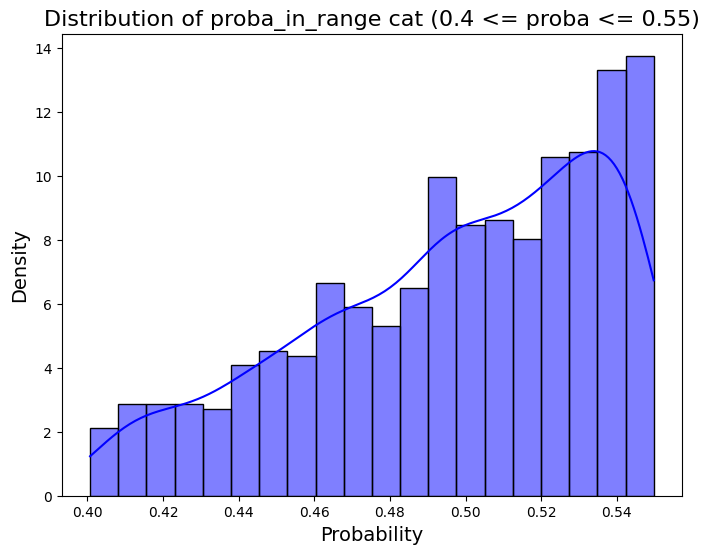

In [96]:
plt.figure(figsize=(8, 6))
sns.histplot(proba_in_range_cat, kde=True, bins=20, color='blue', stat='density')

# 그래프에 제목과 축 라벨 추가
plt.title('Distribution of proba_in_range cat (0.4 <= proba <= 0.55)', fontsize=16)
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Density', fontsize=14)

# 그래프 출력
plt.show()

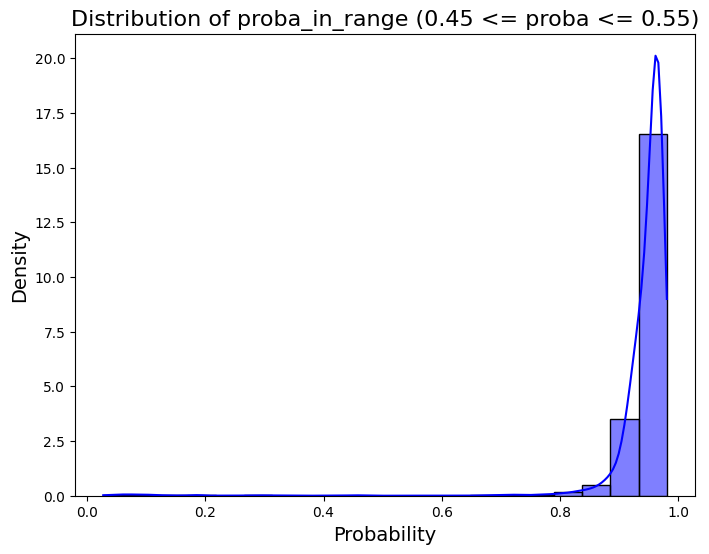

In [97]:
plt.figure(figsize=(8, 6))
sns.histplot(proba_in_range, kde=True, bins=20, color='blue', stat='density')

# 그래프에 제목과 축 라벨 추가
plt.title('Distribution of proba_in_range (0.45 <= proba <= 0.55)', fontsize=16)
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Density', fontsize=14)

# 그래프 출력
plt.show()

In [98]:
predictions = ['Normal' if proba >=threshold_cat else 'AbNormal' for proba in model_cat_proba[:, 1]]

abnormal_count = predictions.count('AbNormal')

print(f"Number of 'AbNormal': {abnormal_count}") # 왜 0.5 0.495 0.48인지 기준이 무엇인지? 평균, 중간으로 기준 정하는 건 어떤지 신뢰구간

Number of 'AbNormal': 695


In [99]:
predictions_knn = ['Normal' if proba >= 0.495 else 'AbNormal' for proba in model_knn_proba[:, 1]]

abnormal_count = predictions_knn.count('AbNormal')

print(f"Number of 'AbNormal': {abnormal_count}") # 0.11 0.89 나오면 어떤 기준을 정할지

Number of 'AbNormal': 77


In [100]:
predictions_hist = ['Normal' if proba >= 0.495 else 'AbNormal' for proba in model_hist_proba[:, 1]]


abnormal_count = predictions_hist.count('AbNormal')

print(f"Number of 'AbNormal': {abnormal_count}")

Number of 'AbNormal': 143


In [101]:
final_predictions = [
    'AbNormal' if [p1, p2, p3].count('AbNormal') >= 1 else 'Normal'
    for p1, p2, p3 in zip(predictions, predictions_knn, predictions_hist)
]

abnormal_count = final_predictions.count('AbNormal')

print(f"Number of 'AbNormal': {abnormal_count}")


Number of 'AbNormal': 709


In [102]:
df_test_x['target'] = final_predictions

In [103]:
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = final_predictions

print((df_sub['target'] == 'AbNormal').sum())

709


In [104]:
# 범주형 5개 + pallete product qty , 등 설정

In [105]:
df_sub.loc[
   df_test_x.loc[((df_test_x['Production Qty Collect Result_Dam']!=df_test_x['Production Qty Collect Result_Fill1'])|
                  (df_test_x['Receip No Collect Result_Fill1']!=df_test_x['Receip No Collect Result_Dam'])|
                  (df_test_x['Production Qty Collect Result_Dam']!=df_test_x['Production Qty Collect Result_Fill2'])|
                  (df_test_x['Production Qty Collect Result_Fill1']!=df_test_x['Production Qty Collect Result_Fill2'])|
                  (df_test_x['PalletID Collect Result_Dam']!=df_test_x['PalletID Collect Result_Fill1'])|
                  (df_test_x['PalletID Collect Result_Dam']!=df_test_x['PalletID Collect Result_Fill2'])|
                  (df_test_x['PalletID Collect Result_Fill1']!=df_test_x['PalletID Collect Result_Fill2']))
                ].index,'target']='AbNormal'
print((df_sub['target'] == 'AbNormal').sum())

709


### 제출 파일 작성


In [106]:
# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
